In [1]:
import random
import numpy as np
import matplotlib.pyplot as pl
import pandas as pd
from sklearn.utils import class_weight
import tensorflow as tf
from tensorflow.keras.losses import categorical_crossentropy
from tensorflow.keras.optimizers import SGD, Adam
from tensorflow.keras import Sequential, activations, Input
from tensorflow.keras.models import Model, load_model
from tensorflow.keras.utils import to_categorical
from tensorflow.keras.layers import (
    BatchNormalization, Activation, SpatialDropout2D, GlobalAveragePooling2D,
    Dense, Dropout, Flatten,
    Conv2D, MaxPooling2D, SeparableConv2D
)
from tensorflow.keras.layers.experimental.preprocessing import Rescaling
from albumentations import Compose

# Import project utils scripts
import os
import sys

src_path = os.path.join('../src/')

if src_path not in sys.path:
    sys.path.append(src_path)

from visualizationUtils import plot_confusion_matrix
from statisticsUtils import recall_precision_fscore_from_confusion_matrix
from lossesUtils import categorical_focal_loss
from bandUtils import Band 
from labelsUtils import (
    Label,
    LabelCategory,
    category_from_label,
    categories_from_label_set
)

from rasterUtils import make_dataset_from_raster_files
from regionUtils import (
    vietnam_labels_coordinates,
    sumatra_south_labels_coordinates,
    sumatra_center_labels_coordinates,
    sulawesi_labels_coordinates,
    para_north_labels_coordinates,
    para_center_labels_coordinates,
    ocotopeque_labels_coordinates,
    ghana_labels_coordinates,
    borneo_labels_coordinates
)
from convNetUtils import (
    images_from_dataset,
    labels_from_dataset,
    cross_validation,
    AUGMENTATIONS,
    ImageMultiOutputSequence,
    train_model,
    evaluate_multi_output_model
)
from config import *

/home/simon/miniconda3/envs/tb/lib/python3.9/site-packages/geopandas/_compat.py:106: UserWarning: The Shapely GEOS version (3.8.0-CAPI-1.13.1 ) is incompatible with the GEOS version PyGEOS was compiled with (3.9.1-CAPI-1.14.2). Conversions between both will be slow.
  warnings.warn(


In [2]:
NB_PIXEL_AROUND = 4
BANDS = [
    Band.COASTAL_AEROSOL.value, 
    Band.BLUE.value, 
    Band.GREEN.value, 
    Band.RED.value, 
    Band.NIR.value, 
    Band.SWIR1.value, 
    Band.SWIR2.value, 
]

In [3]:
# create a dataset per region
datasets = []

labels_coordinates_list = [
    sumatra_south_labels_coordinates(),
    sumatra_center_labels_coordinates(),
    para_north_labels_coordinates(),
    para_center_labels_coordinates(),
    # borneo_labels_coordinates(),
    sulawesi_labels_coordinates(),
    ghana_labels_coordinates(),
    ocotopeque_labels_coordinates()
]

# datasets_name = [
#     'Sumatra_south_2018_whole_year_collection2',
#     'Sumatra_center_2018_whole_year_collection2',
#     'Para_north_2018_whole_year_collection2',
#     'Para_center_2018_whole_year_collection2',
#     # 'Borneo_2018_whole_year_collection2',
#     'Sulawesi_2018_whole_year_collection2',
#     'Ghana_2019_whole_year_collection2',
#     'Ocotopeque_2018_whole_year_collection2'
# ]

datasets_name = [
    'Sumatra_south_2018_january_to_april_collection2',
    'Sumatra_center_2018_january_to_april_collection2',
    'Para_north_2018_january_to_april_collection2',
    'Para_center_2018_january_to_april_collection2',
    # 'Borneo_2018_january_to_april_collection2',
    'Sulawesi_2018_january_to_april_collection2',
    'Ghana_2019_january_to_april_collection2',
    'Ocotopeque_2018_january_to_april_collection2'
]


for i, dataset_name in enumerate(datasets_name):
    labels_coordinates = labels_coordinates_list[i]
    labels = [Label(label) for label in labels_coordinates if len(labels_coordinates[label]) > 5]
    categories = pd.unique([category_from_label(label) for label in labels])
        
    dataset_args = dict(
        labels = labels,
        raster_paths = [os.path.join(DATA_ROOT_PATH, dataset_name, 'merged.tif')],
        labels_coordinates_list = [labels_coordinates],
        nb_pixel_around = NB_PIXEL_AROUND
    )

    dataset = make_dataset_from_raster_files(**dataset_args)
    datasets.append((labels, len(categories), dataset))

KeyboardInterrupt: 

In [118]:
size_min_datasets = min([len(dataset[2]) for dataset in datasets])
print(size_min_datasets)

1082


In [119]:
def task_from_dataset(dataset, labels, labels_names, nb_categories, nb_images=None):
    # Shuffle images order in dataset
    np.random.shuffle(dataset)
    
    if nb_images is not None:
        # Specify a number of images to sample
        dataset = random.choices(dataset, k=nb_images)

    labels_train = labels_from_dataset(dataset, labels_names)
    categories_train = categories_from_label_set(labels, labels_train)
    
    X_train = images_from_dataset(dataset, BANDS)
    y_train = [labels_train, categories_train]
    Y_train = [
        to_categorical(labels_train, num_classes=len(labels_names)), 
        to_categorical(categories_train, num_classes=nb_categories), 
    ]
    
    # Format true label sets for multi output
    Y_train = {
        output_name: Y_train[i] for i, output_name in enumerate(['label', 'category'])
    }
        
    return X_train, Y_train, len(labels_train) / 32


def iteration_tasks(datasets, nb_images=None):
    datasets_order = np.arange(len(datasets))
        
    # Shuffle datasets order
    np.random.shuffle(datasets_order)

    # Loop through every datasets in an iterastion
    for dataset_iter, dataset_idx in enumerate(datasets_order):
        labels, nb_categories, dataset = datasets[dataset_idx]
        labels_names = [label.name for label in labels]
        
        print(f"dataset index: {dataset_idx}, dataset iteration: {dataset_iter + 1}/{len(datasets)}, size: {len(dataset)}")
        
        X_train, Y_train, steps_per_epoch = task_from_dataset(dataset, labels, labels_names, nb_categories, nb_images)
                
        yield X_train, Y_train, steps_per_epoch, dataset_idx, len(labels_names), nb_categories

In [70]:
image_width = 9
image_height = 9
image_depth = len(BANDS)
    
# define model
inputs = Input(shape=(image_width, image_height, image_depth))
layers = Rescaling(0.0000275, offset=0.2)(inputs)
layers = BatchNormalization()(layers)
layers = Conv2D(filters=32, kernel_size=(3, 3), padding="same", activation="relu")(layers)
layers = Conv2D(filters=32, kernel_size=(3, 3), padding="same", activation="relu")(layers)
layers = MaxPooling2D(pool_size=(3, 3))(layers)
layers = Conv2D(filters=64, kernel_size=(3, 3), padding="same", activation="relu")(layers)
layers = Conv2D(filters=64, kernel_size=(3, 3), padding="same", activation="relu")(layers)
layers = MaxPooling2D(pool_size=(3, 3))(layers)
layers = SpatialDropout2D(0.25)(layers)
layers = GlobalAveragePooling2D(name='last_pretrained_layer')(layers)
layers = Dense(128, activation='relu')(layers)
layers = Dropout(0.25, name="last_input_layer")(layers)

label_output = Dense(len(labels), activation='softmax', name="label")(layers)
category_output = Dense(len(LabelCategory), activation='softmax', name="category")(layers)

model = Model(inputs=inputs, outputs=[label_output, category_output])

## v1

In [7]:
# define hyperparameters
meta_step_size = 0.1
nb_iterations = 100
nb_inner_iters = 5
minibatches_size = 32

tasks_output_weights = [None for _ in np.arange(len(datasets))]
datasets_losses = [[] for _ in np.arange(len(datasets))]

for iteration in range(nb_iterations):
    print(f"iteration: {iteration + 1}/{nb_iterations}\n-----------------")
    
    for X_train, Y_train, steps_per_epoch, dataset_idx, nb_labels, nb_categories in iteration_tasks(datasets):
        # Create model with an new output layer for this task
        label_output = Dense(nb_labels, activation='softmax', name="label")(model.get_layer('last_input_layer').output)
        category_output = Dense(nb_categories, activation='softmax', name="category")(model.get_layer('last_input_layer').output)
        
        model = Model(inputs=inputs, outputs=[label_output, category_output])
                
        model.compile(optimizer='adam', loss={
            'label': categorical_focal_loss([[.25] * nb_labels]),
            'category': categorical_focal_loss([[.25] * nb_categories])
        })
        
        # If task as already been trained on, set back the previous weights of the output layer 
        if tasks_output_weights[dataset_idx] is not None :
            model.layers[-1].set_weights(tasks_output_weights[dataset_idx])        

        # Save old weights
        old_weights = model.get_weights()
        
        # Train
        model.fit(
            x=X_train,
            y=Y_train,
            epochs=nb_inner_iters,
            steps_per_epoch=steps_per_epoch,
            verbose=0
        )
        
        # Evaluate model on training data
        score = model.evaluate(X_train, Y_train, verbose=0)
        
        # Get new weights
        new_weights = model.get_weights()
        
        # Store dataset current loss and accuracies
        datasets_losses[dataset_idx].append(float(score[0]))
        
        print(f"- loss: {score[0]}")
        print(datasets_losses)

        # Update weights
        for weight in range(len(new_weights)):
            current_meta_step_size = (1 - iteration / nb_iterations) * meta_step_size
            
            new_weights[weight] = old_weights[weight] + (
                (new_weights[weight] - old_weights[weight]) * current_meta_step_size
            )

        # After the meta-learning step, reload the newly-trained weights into the model.
        model.set_weights(new_weights)

        # Save task's output layer weights
        tasks_output_weights[dataset_idx] = model.layers[-1].get_weights()

iteration: 1/100
-----------------
dataset index: 3, dataset iteration: 1/8, size: 20687
- loss: 0.05874073877930641
dataset index: 1, dataset iteration: 2/8, size: 2155
- loss: 0.46985748410224915
dataset index: 2, dataset iteration: 3/8, size: 2234
- loss: 0.14396362006664276
dataset index: 0, dataset iteration: 4/8, size: 11477
- loss: 0.07297229021787643
dataset index: 4, dataset iteration: 5/8, size: 89
- loss: 0.465379536151886
dataset index: 5, dataset iteration: 6/8, size: 3168
- loss: 0.32658612728118896
dataset index: 6, dataset iteration: 7/8, size: 7356
- loss: 0.35134708881378174
dataset index: 7, dataset iteration: 8/8, size: 59317
- loss: 0.06430808454751968
iteration: 2/100
-----------------
dataset index: 7, dataset iteration: 1/8, size: 59317
- loss: 0.06120006740093231
dataset index: 3, dataset iteration: 2/8, size: 20687
- loss: 0.04855780676007271
dataset index: 5, dataset iteration: 3/8, size: 3168
- loss: 0.27057743072509766
dataset index: 4, dataset iteration: 4

- loss: 0.2082163393497467
dataset index: 3, dataset iteration: 2/8, size: 20687
- loss: 0.022002479061484337
dataset index: 4, dataset iteration: 3/8, size: 89
- loss: 0.2222290188074112
dataset index: 5, dataset iteration: 4/8, size: 3168
- loss: 0.06961492449045181
dataset index: 7, dataset iteration: 5/8, size: 59317
- loss: 0.03367201238870621
dataset index: 0, dataset iteration: 6/8, size: 11477
- loss: 0.02999242953956127
dataset index: 1, dataset iteration: 7/8, size: 2155
- loss: 0.08175142854452133
dataset index: 2, dataset iteration: 8/8, size: 2234
- loss: 0.00706707127392292
iteration: 14/100
-----------------
dataset index: 2, dataset iteration: 1/8, size: 2234
- loss: 0.0142222223803401
dataset index: 5, dataset iteration: 2/8, size: 3168
- loss: 0.07136567682027817
dataset index: 0, dataset iteration: 3/8, size: 11477
- loss: 0.031228486448526382
dataset index: 4, dataset iteration: 4/8, size: 89
- loss: 0.14225828647613525
dataset index: 3, dataset iteration: 5/8, size

- loss: 0.016033008694648743
dataset index: 5, dataset iteration: 2/8, size: 3168
- loss: 0.05186954140663147
dataset index: 7, dataset iteration: 3/8, size: 59317
- loss: 0.026420269161462784
dataset index: 2, dataset iteration: 4/8, size: 2234
- loss: 0.0011027901200577617
dataset index: 4, dataset iteration: 5/8, size: 89
- loss: 0.12335013598203659
dataset index: 6, dataset iteration: 6/8, size: 7356
- loss: 0.1691891849040985
dataset index: 1, dataset iteration: 7/8, size: 2155
- loss: 0.07116086035966873
dataset index: 0, dataset iteration: 8/8, size: 11477
- loss: 0.02018759772181511
iteration: 26/100
-----------------
dataset index: 2, dataset iteration: 1/8, size: 2234
- loss: 0.0023105896543711424
dataset index: 7, dataset iteration: 2/8, size: 59317
- loss: 0.02791651338338852
dataset index: 1, dataset iteration: 3/8, size: 2155
- loss: 0.06250021606683731
dataset index: 3, dataset iteration: 4/8, size: 20687
- loss: 0.021997282281517982
dataset index: 0, dataset iteration: 

- loss: 0.12894323468208313
dataset index: 0, dataset iteration: 2/8, size: 11477
- loss: 0.015890592709183693
dataset index: 1, dataset iteration: 3/8, size: 2155
- loss: 0.053174108266830444
dataset index: 3, dataset iteration: 4/8, size: 20687
- loss: 0.012095370329916477
dataset index: 2, dataset iteration: 5/8, size: 2234
- loss: 0.004262649919837713
dataset index: 6, dataset iteration: 6/8, size: 7356
- loss: 0.1337817758321762
dataset index: 7, dataset iteration: 7/8, size: 59317
- loss: 0.02238648012280464
dataset index: 5, dataset iteration: 8/8, size: 3168
- loss: 0.043892018496990204
iteration: 38/100
-----------------
dataset index: 7, dataset iteration: 1/8, size: 59317
- loss: 0.022438732907176018
dataset index: 5, dataset iteration: 2/8, size: 3168
- loss: 0.04514046013355255
dataset index: 6, dataset iteration: 3/8, size: 7356
- loss: 0.14121542870998383
dataset index: 3, dataset iteration: 4/8, size: 20687
- loss: 0.01293379906564951
dataset index: 2, dataset iteration

- loss: 0.01028909906744957
dataset index: 5, dataset iteration: 2/8, size: 3168
- loss: 0.04063040763139725
dataset index: 6, dataset iteration: 3/8, size: 7356
- loss: 0.11893081665039062
dataset index: 2, dataset iteration: 4/8, size: 2234
- loss: 0.002111084759235382
dataset index: 7, dataset iteration: 5/8, size: 59317
- loss: 0.017898518592119217
dataset index: 1, dataset iteration: 6/8, size: 2155
- loss: 0.04891146346926689
dataset index: 4, dataset iteration: 7/8, size: 89
- loss: 0.11106859892606735
dataset index: 0, dataset iteration: 8/8, size: 11477
- loss: 0.013723799958825111
iteration: 50/100
-----------------
dataset index: 6, dataset iteration: 1/8, size: 7356
- loss: 0.12276331335306168
dataset index: 0, dataset iteration: 2/8, size: 11477
- loss: 0.016380053013563156
dataset index: 1, dataset iteration: 3/8, size: 2155
- loss: 0.04225985333323479
dataset index: 7, dataset iteration: 4/8, size: 59317
- loss: 0.01914667896926403
dataset index: 3, dataset iteration: 5/

- loss: 0.018794236704707146
dataset index: 0, dataset iteration: 2/8, size: 11477
- loss: 0.013808677904307842
dataset index: 6, dataset iteration: 3/8, size: 7356
- loss: 0.11425059288740158
dataset index: 2, dataset iteration: 4/8, size: 2234
- loss: 0.0008717922610230744
dataset index: 5, dataset iteration: 5/8, size: 3168
- loss: 0.03600792586803436
dataset index: 3, dataset iteration: 6/8, size: 20687
- loss: 0.010811951011419296
dataset index: 1, dataset iteration: 7/8, size: 2155
- loss: 0.0389619916677475
dataset index: 4, dataset iteration: 8/8, size: 89
- loss: 0.12471221387386322
iteration: 62/100
-----------------
dataset index: 6, dataset iteration: 1/8, size: 7356
- loss: 0.10856065899133682
dataset index: 3, dataset iteration: 2/8, size: 20687
- loss: 0.008869224227964878
dataset index: 0, dataset iteration: 3/8, size: 11477
- loss: 0.017112741246819496
dataset index: 7, dataset iteration: 4/8, size: 59317
- loss: 0.020448394119739532
dataset index: 2, dataset iteration

- loss: 0.03254096955060959
dataset index: 3, dataset iteration: 2/8, size: 20687
- loss: 0.013668871484696865
dataset index: 0, dataset iteration: 3/8, size: 11477
- loss: 0.01184204313904047
dataset index: 7, dataset iteration: 4/8, size: 59317
- loss: 0.0167051050812006
dataset index: 6, dataset iteration: 5/8, size: 7356
- loss: 0.11214657872915268
dataset index: 2, dataset iteration: 6/8, size: 2234
- loss: 0.0017862959066405892
dataset index: 4, dataset iteration: 7/8, size: 89
- loss: 0.1067841425538063
dataset index: 1, dataset iteration: 8/8, size: 2155
- loss: 0.03540033847093582
iteration: 74/100
-----------------
dataset index: 7, dataset iteration: 1/8, size: 59317
- loss: 0.01889627054333687
dataset index: 4, dataset iteration: 2/8, size: 89
- loss: 0.10121221095323563
dataset index: 0, dataset iteration: 3/8, size: 11477
- loss: 0.012824027799069881
dataset index: 1, dataset iteration: 4/8, size: 2155
- loss: 0.04058394581079483
dataset index: 3, dataset iteration: 5/8, 

- loss: 0.008902141824364662
dataset index: 7, dataset iteration: 2/8, size: 59317
- loss: 0.01761518605053425
dataset index: 1, dataset iteration: 3/8, size: 2155
- loss: 0.04433947801589966
dataset index: 0, dataset iteration: 4/8, size: 11477
- loss: 0.012736620381474495
dataset index: 2, dataset iteration: 5/8, size: 2234
- loss: 0.0007028162362985313
dataset index: 5, dataset iteration: 6/8, size: 3168
- loss: 0.02909163571894169
dataset index: 4, dataset iteration: 7/8, size: 89
- loss: 0.10435602813959122
dataset index: 6, dataset iteration: 8/8, size: 7356
- loss: 0.10982891172170639
iteration: 86/100
-----------------
dataset index: 3, dataset iteration: 1/8, size: 20687
- loss: 0.012202258221805096
dataset index: 5, dataset iteration: 2/8, size: 3168
- loss: 0.027286062017083168
dataset index: 4, dataset iteration: 3/8, size: 89
- loss: 0.09406624734401703
dataset index: 2, dataset iteration: 4/8, size: 2234
- loss: 0.0006127496599219739
dataset index: 0, dataset iteration: 5

- loss: 0.00886926706880331
dataset index: 1, dataset iteration: 2/8, size: 2155
- loss: 0.04531380906701088
dataset index: 5, dataset iteration: 3/8, size: 3168
- loss: 0.02915113791823387
dataset index: 6, dataset iteration: 4/8, size: 7356
- loss: 0.10564421117305756
dataset index: 2, dataset iteration: 5/8, size: 2234
- loss: 0.0016468653921037912
dataset index: 7, dataset iteration: 6/8, size: 59317
- loss: 0.017096631228923798
dataset index: 0, dataset iteration: 7/8, size: 11477
- loss: 0.014657813124358654
dataset index: 4, dataset iteration: 8/8, size: 89
- loss: 0.11893685907125473
iteration: 98/100
-----------------
dataset index: 5, dataset iteration: 1/8, size: 3168
- loss: 0.0322287417948246
dataset index: 1, dataset iteration: 2/8, size: 2155
- loss: 0.03626882657408714
dataset index: 4, dataset iteration: 3/8, size: 89
- loss: 0.09438557922840118
dataset index: 2, dataset iteration: 4/8, size: 2234
- loss: 0.0010346490889787674
dataset index: 3, dataset iteration: 5/8, 

0.014803510159254074
0.037254635244607925
0.0010234233923256397
0.007154997903853655
0.12222884595394135
0.03301871567964554
0.10456104576587677
0.016448354348540306


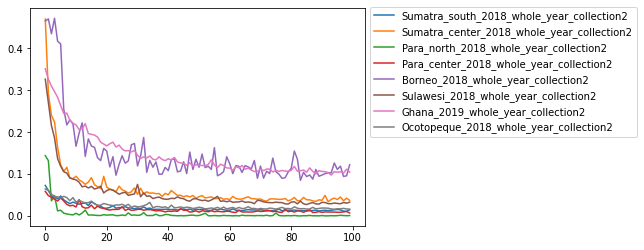

In [8]:
for dataset_idx in np.arange(len(datasets)):
    pl.plot(datasets_losses[dataset_idx], label=datasets_name[dataset_idx])
    
    print(datasets_losses[dataset_idx][-1])

pl.legend(bbox_to_anchor=(1, 1.03))

In [9]:
# remove last layer
model = Model(inputs=model.input, outputs=model.get_layer('last_input_layer').output)

# save model
model.save(os.path.join(MODEL_ROOT_PATH, 'multi_output_pretrained_with_reptile.hdf5'))

## v2 (without borneo, diff hyperparameters)

In [7]:
# define hyperparameters
meta_step_size = 0.35
nb_iterations = 100
nb_inner_iters = 5
minibatches_size = 32

tasks_output_weights = [None for _ in np.arange(len(datasets))]
datasets_losses = [[] for _ in np.arange(len(datasets))]

for iteration in range(nb_iterations):
    print(f"iteration: {iteration + 1}/{nb_iterations}\n-----------------")
    
    for X_train, Y_train, steps_per_epoch, dataset_idx, nb_labels, nb_categories in iteration_tasks(datasets):
        # Create model with an new output layer for this task
        label_output = Dense(nb_labels, activation='softmax', name="label")(model.get_layer('last_input_layer').output)
        category_output = Dense(nb_categories, activation='softmax', name="category")(model.get_layer('last_input_layer').output)
        
        model = Model(inputs=inputs, outputs=[label_output, category_output])

        model.compile(optimizer='adam', loss={
            'label': categorical_focal_loss([[.25] * nb_labels]),
            'category': categorical_focal_loss([[.25] * nb_categories])
        })
        
        # If task as already been trained on, set back the previous weights of the output layer 
        if tasks_output_weights[dataset_idx] is not None :
            model.layers[-1].set_weights(tasks_output_weights[dataset_idx])        

        # Save old weights
        old_weights = model.get_weights()
        
        # Train
        model.fit(
            x=X_train,
            y=Y_train,
            epochs=nb_inner_iters,
            steps_per_epoch=steps_per_epoch,
            verbose=0
        )
        
        # Evaluate model on training data
        score = model.evaluate(X_train, Y_train, verbose=0)
        
        # Get new weights
        new_weights = model.get_weights()
        
        # Store dataset current loss and accuracies
        datasets_losses[dataset_idx].append(float(score[0]))
        
        print(f"- loss: {score[0]}")

        # Update weights
        for weight in range(len(new_weights)):
            current_meta_step_size = (1 - iteration / nb_iterations) * meta_step_size
            
            new_weights[weight] = old_weights[weight] + (
                (new_weights[weight] - old_weights[weight]) * current_meta_step_size
            )

        # After the meta-learning step, reload the newly-trained weights into the model.
        model.set_weights(new_weights)

        # Save task's output layer weights
        tasks_output_weights[dataset_idx] = model.layers[-1].get_weights()

iteration: 1/100
-----------------
dataset index: 2, dataset iteration: 1/7, size: 2234
- loss: 0.22837373614311218
dataset index: 6, dataset iteration: 2/7, size: 59317
- loss: 0.05864027142524719
dataset index: 0, dataset iteration: 3/7, size: 11477
- loss: 0.06247253343462944
dataset index: 1, dataset iteration: 4/7, size: 2155
- loss: 0.2386702001094818
dataset index: 4, dataset iteration: 5/7, size: 3168
- loss: 0.1683434695005417
dataset index: 5, dataset iteration: 6/7, size: 7356
- loss: 0.2984572947025299
dataset index: 3, dataset iteration: 7/7, size: 20687
- loss: 0.049004100263118744
iteration: 2/100
-----------------
dataset index: 4, dataset iteration: 1/7, size: 3168
- loss: 0.13808338344097137
dataset index: 3, dataset iteration: 2/7, size: 20687
- loss: 0.037848323583602905
dataset index: 2, dataset iteration: 3/7, size: 2234
- loss: 0.012377305887639523
dataset index: 1, dataset iteration: 4/7, size: 2155
- loss: 0.12109982222318649
dataset index: 0, dataset iteration

- loss: 0.06159753352403641
dataset index: 2, dataset iteration: 5/7, size: 2234
- loss: 0.004233239218592644
dataset index: 5, dataset iteration: 6/7, size: 7356
- loss: 0.1582956165075302
dataset index: 1, dataset iteration: 7/7, size: 2155
- loss: 0.08046333491802216
iteration: 15/100
-----------------
dataset index: 3, dataset iteration: 1/7, size: 20687
- loss: 0.016421297565102577
dataset index: 5, dataset iteration: 2/7, size: 7356
- loss: 0.14154456555843353
dataset index: 4, dataset iteration: 3/7, size: 3168
- loss: 0.051530733704566956
dataset index: 6, dataset iteration: 4/7, size: 59317
- loss: 0.020726224407553673
dataset index: 0, dataset iteration: 5/7, size: 11477
- loss: 0.026224171742796898
dataset index: 2, dataset iteration: 6/7, size: 2234
- loss: 0.002062334679067135
dataset index: 1, dataset iteration: 7/7, size: 2155
- loss: 0.07418522983789444
iteration: 16/100
-----------------
dataset index: 2, dataset iteration: 1/7, size: 2234
- loss: 0.0014605040196329355

- loss: 0.011445869691669941
dataset index: 5, dataset iteration: 2/7, size: 7356
- loss: 0.11453811824321747
dataset index: 1, dataset iteration: 3/7, size: 2155
- loss: 0.051065266132354736
dataset index: 4, dataset iteration: 4/7, size: 3168
- loss: 0.04354932904243469
dataset index: 0, dataset iteration: 5/7, size: 11477
- loss: 0.018215317279100418
dataset index: 6, dataset iteration: 6/7, size: 59317
- loss: 0.015247640199959278
dataset index: 2, dataset iteration: 7/7, size: 2234
- loss: 0.0015085303457453847
iteration: 29/100
-----------------
dataset index: 3, dataset iteration: 1/7, size: 20687
- loss: 0.010852454230189323
dataset index: 0, dataset iteration: 2/7, size: 11477
- loss: 0.01629095897078514
dataset index: 6, dataset iteration: 3/7, size: 59317
- loss: 0.015142182819545269
dataset index: 1, dataset iteration: 4/7, size: 2155
- loss: 0.06569081544876099
dataset index: 2, dataset iteration: 5/7, size: 2234
- loss: 0.0015143542550504208
dataset index: 4, dataset iter

- loss: 0.010563039220869541
dataset index: 1, dataset iteration: 6/7, size: 2155
- loss: 0.04535498470067978
dataset index: 0, dataset iteration: 7/7, size: 11477
- loss: 0.014831437729299068
iteration: 42/100
-----------------
dataset index: 3, dataset iteration: 1/7, size: 20687
- loss: 0.01270836777985096
dataset index: 6, dataset iteration: 2/7, size: 59317
- loss: 0.014905565418303013
dataset index: 4, dataset iteration: 3/7, size: 3168
- loss: 0.03728567808866501
dataset index: 1, dataset iteration: 4/7, size: 2155
- loss: 0.04571298509836197
dataset index: 5, dataset iteration: 5/7, size: 7356
- loss: 0.09958492964506149
dataset index: 0, dataset iteration: 6/7, size: 11477
- loss: 0.015623146668076515
dataset index: 2, dataset iteration: 7/7, size: 2234
- loss: 0.0029612004291266203
iteration: 43/100
-----------------
dataset index: 3, dataset iteration: 1/7, size: 20687
- loss: 0.010102611035108566
dataset index: 4, dataset iteration: 2/7, size: 3168
- loss: 0.037148013710975

- loss: 0.03780536726117134
dataset index: 0, dataset iteration: 2/7, size: 11477
- loss: 0.012653167359530926
dataset index: 2, dataset iteration: 3/7, size: 2234
- loss: 0.0006488476064987481
dataset index: 6, dataset iteration: 4/7, size: 59317
- loss: 0.011900676414370537
dataset index: 4, dataset iteration: 5/7, size: 3168
- loss: 0.031876929104328156
dataset index: 5, dataset iteration: 6/7, size: 7356
- loss: 0.09523771703243256
dataset index: 3, dataset iteration: 7/7, size: 20687
- loss: 0.00993531383574009
iteration: 56/100
-----------------
dataset index: 5, dataset iteration: 1/7, size: 7356
- loss: 0.08554358780384064
dataset index: 3, dataset iteration: 2/7, size: 20687
- loss: 0.008672548457980156
dataset index: 1, dataset iteration: 3/7, size: 2155
- loss: 0.0382230207324028
dataset index: 0, dataset iteration: 4/7, size: 11477
- loss: 0.013590198010206223
dataset index: 6, dataset iteration: 5/7, size: 59317
- loss: 0.011935430578887463
dataset index: 2, dataset iterat

- loss: 0.0007916903705336154
dataset index: 4, dataset iteration: 6/7, size: 3168
- loss: 0.028798433020710945
dataset index: 3, dataset iteration: 7/7, size: 20687
- loss: 0.008925446309149265
iteration: 69/100
-----------------
dataset index: 6, dataset iteration: 1/7, size: 59317
- loss: 0.016082653775811195
dataset index: 0, dataset iteration: 2/7, size: 11477
- loss: 0.013022557832300663
dataset index: 5, dataset iteration: 3/7, size: 7356
- loss: 0.08819007873535156
dataset index: 4, dataset iteration: 4/7, size: 3168
- loss: 0.029817180708050728
dataset index: 2, dataset iteration: 5/7, size: 2234
- loss: 0.0014797840267419815
dataset index: 3, dataset iteration: 6/7, size: 20687
- loss: 0.00809809472411871
dataset index: 1, dataset iteration: 7/7, size: 2155
- loss: 0.034877706319093704
iteration: 70/100
-----------------
dataset index: 5, dataset iteration: 1/7, size: 7356
- loss: 0.07706987857818604
dataset index: 1, dataset iteration: 2/7, size: 2155
- loss: 0.0329632423818

- loss: 0.00746016763150692
dataset index: 2, dataset iteration: 2/7, size: 2234
- loss: 0.0003603109216783196
dataset index: 6, dataset iteration: 3/7, size: 59317
- loss: 0.010981017723679543
dataset index: 4, dataset iteration: 4/7, size: 3168
- loss: 0.02766234055161476
dataset index: 1, dataset iteration: 5/7, size: 2155
- loss: 0.03221999853849411
dataset index: 0, dataset iteration: 6/7, size: 11477
- loss: 0.010977975092828274
dataset index: 5, dataset iteration: 7/7, size: 7356
- loss: 0.08028773218393326
iteration: 83/100
-----------------
dataset index: 4, dataset iteration: 1/7, size: 3168
- loss: 0.023803815245628357
dataset index: 1, dataset iteration: 2/7, size: 2155
- loss: 0.03155720978975296
dataset index: 6, dataset iteration: 3/7, size: 59317
- loss: 0.01037798635661602
dataset index: 2, dataset iteration: 4/7, size: 2234
- loss: 0.0009161095949821174
dataset index: 3, dataset iteration: 5/7, size: 20687
- loss: 0.009289964102208614
dataset index: 5, dataset iterati

- loss: 0.010612953454256058
dataset index: 5, dataset iteration: 6/7, size: 7356
- loss: 0.07514750957489014
dataset index: 6, dataset iteration: 7/7, size: 59317
- loss: 0.010026863776147366
iteration: 96/100
-----------------
dataset index: 6, dataset iteration: 1/7, size: 59317
- loss: 0.011241300031542778
dataset index: 1, dataset iteration: 2/7, size: 2155
- loss: 0.032554447650909424
dataset index: 0, dataset iteration: 3/7, size: 11477
- loss: 0.010829519480466843
dataset index: 4, dataset iteration: 4/7, size: 3168
- loss: 0.025691857561469078
dataset index: 3, dataset iteration: 5/7, size: 20687
- loss: 0.00754750519990921
dataset index: 5, dataset iteration: 6/7, size: 7356
- loss: 0.07573681324720383
dataset index: 2, dataset iteration: 7/7, size: 2234
- loss: 0.0008717932505533099
iteration: 97/100
-----------------
dataset index: 2, dataset iteration: 1/7, size: 2234
- loss: 0.0015039496356621385
dataset index: 5, dataset iteration: 2/7, size: 7356
- loss: 0.0782542824745

0.01112225092947483
0.029041964560747147
0.0005029580788686872
0.0072794160805642605
0.024312175810337067
0.07720689475536346
0.012711836956441402


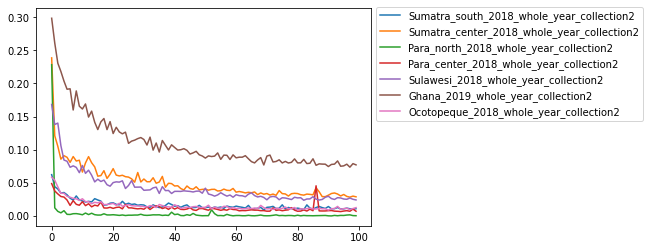

In [8]:
for dataset_idx in np.arange(len(datasets)):
    pl.plot(datasets_losses[dataset_idx], label=datasets_name[dataset_idx])
    
    print(datasets_losses[dataset_idx][-1])

pl.legend(bbox_to_anchor=(1, 1.03))

In [9]:
# remove last layer
model = Model(inputs=model.input, outputs=model.get_layer('last_pretrained_layer').output)

# save model
model.save(os.path.join(MODEL_ROOT_PATH, 'multi_output_pretrained_with_reptile_v2.hdf5'))

## v3 (categorical cross entropy, diff hyperparameters, without borneo)

In [7]:
# define hyperparameters
meta_step_size = 0.25
nb_iterations = 100
nb_inner_iters = 3
minibatches_size = 32

tasks_output_weights = [None for _ in np.arange(len(datasets))]
datasets_losses = [[] for _ in np.arange(len(datasets))]

for iteration in range(nb_iterations):
    print(f"iteration: {iteration + 1}/{nb_iterations}\n-----------------")
    
    for X_train, Y_train, steps_per_epoch, dataset_idx, nb_labels, nb_categories in iteration_tasks(datasets):
        # Create model with an new output layer for this task
        label_output = Dense(nb_labels, activation='softmax', name="label")(model.get_layer('last_input_layer').output)
        category_output = Dense(nb_categories, activation='softmax', name="category")(model.get_layer('last_input_layer').output)
        
        model = Model(inputs=inputs, outputs=[label_output, category_output])

        model.compile(optimizer='adam', loss={
            'label': 'categorical_crossentropy',
            'category': 'categorical_crossentropy'
        })
        
        # If task as already been trained on, set back the previous weights of the output layer 
        if tasks_output_weights[dataset_idx] is not None :
            model.layers[-1].set_weights(tasks_output_weights[dataset_idx])        

        # Save old weights
        old_weights = model.get_weights()
        
        # Train
        model.fit(
            x=X_train,
            y=Y_train,
            epochs=nb_inner_iters,
            steps_per_epoch=steps_per_epoch,
            verbose=0
        )
        
        # Evaluate model on training data
        score = model.evaluate(X_train, Y_train, verbose=0)
        
        # Get new weights
        new_weights = model.get_weights()
        
        # Store dataset current loss and accuracies
        datasets_losses[dataset_idx].append(float(score[0]))
        
        print(f"- loss: {score[0]}")

        # Update weights
        for weight in range(len(new_weights)):
            current_meta_step_size = (1 - iteration / nb_iterations) * meta_step_size
            
            new_weights[weight] = old_weights[weight] + (
                (new_weights[weight] - old_weights[weight]) * current_meta_step_size
            )

        # After the meta-learning step, reload the newly-trained weights into the model.
        model.set_weights(new_weights)

        # Save task's output layer weights
        tasks_output_weights[dataset_idx] = model.layers[-1].get_weights()

iteration: 1/100
-----------------
dataset index: 5, dataset iteration: 1/7, size: 7356
- loss: 2.645271062850952
dataset index: 6, dataset iteration: 2/7, size: 59317
- loss: 0.6939663290977478
dataset index: 0, dataset iteration: 3/7, size: 11477
- loss: 0.7448346018791199
dataset index: 2, dataset iteration: 4/7, size: 2234
- loss: 0.8922483325004578
dataset index: 4, dataset iteration: 5/7, size: 3168
- loss: 3.235975503921509
dataset index: 3, dataset iteration: 6/7, size: 20687
- loss: 0.4891805350780487
dataset index: 1, dataset iteration: 7/7, size: 2155
- loss: 3.6300487518310547
iteration: 2/100
-----------------
dataset index: 6, dataset iteration: 1/7, size: 59317
- loss: 0.5999603867530823
dataset index: 5, dataset iteration: 2/7, size: 7356
- loss: 2.2194716930389404
dataset index: 0, dataset iteration: 3/7, size: 11477
- loss: 0.5400900840759277
dataset index: 2, dataset iteration: 4/7, size: 2234
- loss: 0.6121430397033691
dataset index: 4, dataset iteration: 5/7, size:

- loss: 0.3155023157596588
dataset index: 5, dataset iteration: 6/7, size: 7356
- loss: 1.6071799993515015
dataset index: 3, dataset iteration: 7/7, size: 20687
- loss: 0.2723288834095001
iteration: 15/100
-----------------
dataset index: 5, dataset iteration: 1/7, size: 7356
- loss: 1.576157569885254
dataset index: 0, dataset iteration: 2/7, size: 11477
- loss: 0.29896172881126404
dataset index: 3, dataset iteration: 3/7, size: 20687
- loss: 0.2277812510728836
dataset index: 6, dataset iteration: 4/7, size: 59317
- loss: 0.2927475869655609
dataset index: 1, dataset iteration: 5/7, size: 2155
- loss: 1.000669002532959
dataset index: 2, dataset iteration: 6/7, size: 2234
- loss: 0.07189231365919113
dataset index: 4, dataset iteration: 7/7, size: 3168
- loss: 0.8330146074295044
iteration: 16/100
-----------------
dataset index: 1, dataset iteration: 1/7, size: 2155
- loss: 0.9283580183982849
dataset index: 6, dataset iteration: 2/7, size: 59317
- loss: 0.27939754724502563
dataset index: 

- loss: 0.038415659219026566
dataset index: 1, dataset iteration: 4/7, size: 2155
- loss: 0.7942165732383728
dataset index: 4, dataset iteration: 5/7, size: 3168
- loss: 0.7337788343429565
dataset index: 5, dataset iteration: 6/7, size: 7356
- loss: 1.483350396156311
dataset index: 0, dataset iteration: 7/7, size: 11477
- loss: 0.2724664807319641
iteration: 29/100
-----------------
dataset index: 3, dataset iteration: 1/7, size: 20687
- loss: 0.2029096633195877
dataset index: 5, dataset iteration: 2/7, size: 7356
- loss: 1.3646581172943115
dataset index: 6, dataset iteration: 3/7, size: 59317
- loss: 0.19675201177597046
dataset index: 0, dataset iteration: 4/7, size: 11477
- loss: 0.24656426906585693
dataset index: 1, dataset iteration: 5/7, size: 2155
- loss: 0.7806363701820374
dataset index: 4, dataset iteration: 6/7, size: 3168
- loss: 0.7311043739318848
dataset index: 2, dataset iteration: 7/7, size: 2234
- loss: 0.05741839110851288
iteration: 30/100
-----------------
dataset index

- loss: 0.5931488871574402
dataset index: 3, dataset iteration: 2/7, size: 20687
- loss: 0.15225794911384583
dataset index: 5, dataset iteration: 3/7, size: 7356
- loss: 1.2038782835006714
dataset index: 6, dataset iteration: 4/7, size: 59317
- loss: 0.1736835092306137
dataset index: 1, dataset iteration: 5/7, size: 2155
- loss: 0.6738225817680359
dataset index: 0, dataset iteration: 6/7, size: 11477
- loss: 0.19504383206367493
dataset index: 2, dataset iteration: 7/7, size: 2234
- loss: 0.05284912884235382
iteration: 43/100
-----------------
dataset index: 5, dataset iteration: 1/7, size: 7356
- loss: 1.2295292615890503
dataset index: 0, dataset iteration: 2/7, size: 11477
- loss: 0.21663254499435425
dataset index: 4, dataset iteration: 3/7, size: 3168
- loss: 0.6003043055534363
dataset index: 3, dataset iteration: 4/7, size: 20687
- loss: 0.2316996306180954
dataset index: 6, dataset iteration: 5/7, size: 59317
- loss: 0.17901067435741425
dataset index: 2, dataset iteration: 6/7, size

- loss: 1.1876494884490967
dataset index: 1, dataset iteration: 7/7, size: 2155
- loss: 0.6630228757858276
iteration: 56/100
-----------------
dataset index: 1, dataset iteration: 1/7, size: 2155
- loss: 0.572395384311676
dataset index: 6, dataset iteration: 2/7, size: 59317
- loss: 0.16366465389728546
dataset index: 5, dataset iteration: 3/7, size: 7356
- loss: 1.166029453277588
dataset index: 0, dataset iteration: 4/7, size: 11477
- loss: 0.21520201861858368
dataset index: 3, dataset iteration: 5/7, size: 20687
- loss: 0.13603322207927704
dataset index: 4, dataset iteration: 6/7, size: 3168
- loss: 0.6109930872917175
dataset index: 2, dataset iteration: 7/7, size: 2234
- loss: 0.035591334104537964
iteration: 57/100
-----------------
dataset index: 4, dataset iteration: 1/7, size: 3168
- loss: 0.49700281023979187
dataset index: 5, dataset iteration: 2/7, size: 7356
- loss: 1.1982755661010742
dataset index: 1, dataset iteration: 3/7, size: 2155
- loss: 0.6252008676528931
dataset index:

- loss: 0.17256906628608704
dataset index: 5, dataset iteration: 4/7, size: 7356
- loss: 1.1211334466934204
dataset index: 2, dataset iteration: 5/7, size: 2234
- loss: 0.029067879542708397
dataset index: 4, dataset iteration: 6/7, size: 3168
- loss: 0.48654845356941223
dataset index: 0, dataset iteration: 7/7, size: 11477
- loss: 0.18011029064655304
iteration: 70/100
-----------------
dataset index: 4, dataset iteration: 1/7, size: 3168
- loss: 0.5044258832931519
dataset index: 5, dataset iteration: 2/7, size: 7356
- loss: 1.1081323623657227
dataset index: 0, dataset iteration: 3/7, size: 11477
- loss: 0.20655007660388947
dataset index: 3, dataset iteration: 4/7, size: 20687
- loss: 0.12691178917884827
dataset index: 6, dataset iteration: 5/7, size: 59317
- loss: 0.1427401751279831
dataset index: 2, dataset iteration: 6/7, size: 2234
- loss: 0.026222053915262222
dataset index: 1, dataset iteration: 7/7, size: 2155
- loss: 0.6649698615074158
iteration: 71/100
-----------------
dataset 

- loss: 0.01706850528717041
dataset index: 3, dataset iteration: 2/7, size: 20687
- loss: 0.16238853335380554
dataset index: 5, dataset iteration: 3/7, size: 7356
- loss: 1.093430995941162
dataset index: 4, dataset iteration: 4/7, size: 3168
- loss: 0.4982076585292816
dataset index: 0, dataset iteration: 5/7, size: 11477
- loss: 0.15266643464565277
dataset index: 1, dataset iteration: 6/7, size: 2155
- loss: 0.5254852175712585
dataset index: 6, dataset iteration: 7/7, size: 59317
- loss: 0.14495490491390228
iteration: 84/100
-----------------
dataset index: 3, dataset iteration: 1/7, size: 20687
- loss: 0.1422063559293747
dataset index: 6, dataset iteration: 2/7, size: 59317
- loss: 0.14286503195762634
dataset index: 0, dataset iteration: 3/7, size: 11477
- loss: 0.16970090568065643
dataset index: 1, dataset iteration: 4/7, size: 2155
- loss: 0.6429236531257629
dataset index: 2, dataset iteration: 5/7, size: 2234
- loss: 0.03167140111327171
dataset index: 4, dataset iteration: 6/7, siz

- loss: 0.13634426891803741
dataset index: 0, dataset iteration: 7/7, size: 11477
- loss: 0.1828453242778778
iteration: 97/100
-----------------
dataset index: 5, dataset iteration: 1/7, size: 7356
- loss: 1.0284982919692993
dataset index: 3, dataset iteration: 2/7, size: 20687
- loss: 0.11933256685733795
dataset index: 6, dataset iteration: 3/7, size: 59317
- loss: 0.14403802156448364
dataset index: 1, dataset iteration: 4/7, size: 2155
- loss: 0.5945358276367188
dataset index: 4, dataset iteration: 5/7, size: 3168
- loss: 0.5016205310821533
dataset index: 0, dataset iteration: 6/7, size: 11477
- loss: 0.1636107861995697
dataset index: 2, dataset iteration: 7/7, size: 2234
- loss: 0.02276225946843624
iteration: 98/100
-----------------
dataset index: 6, dataset iteration: 1/7, size: 59317
- loss: 0.14127923548221588
dataset index: 0, dataset iteration: 2/7, size: 11477
- loss: 0.15291836857795715
dataset index: 2, dataset iteration: 3/7, size: 2234
- loss: 0.01903621107339859
dataset 

0.18400022387504578
0.4985332787036896
0.024219097569584846
0.11804495751857758
0.4584929347038269
1.0720536708831787
0.13282929360866547


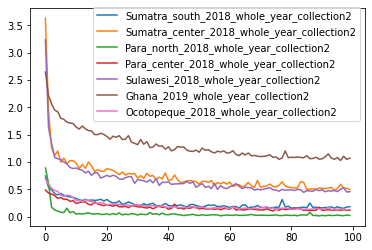

In [8]:
for dataset_idx in np.arange(len(datasets)):
    pl.plot(datasets_losses[dataset_idx], label=datasets_name[dataset_idx])
    
    print(datasets_losses[dataset_idx][-1])

pl.legend(bbox_to_anchor=(1, 1.03))

In [9]:
# remove last layer
model = Model(inputs=model.input, outputs=model.get_layer('last_input_layer').output)

# save model
model.save(os.path.join(MODEL_ROOT_PATH, 'multi_output_pretrained_with_reptile_v3.hdf5'))

### V4 (same as v2 but with different architecture and more iterations)

In [ ]:
image_width = 9
image_height = 9
image_depth = len(BANDS)

inputs = Input(shape=(image_width, image_height, image_depth))
layers = Rescaling(0.0000275, offset=0.2)(inputs)
layers = BatchNormalization()(layers)
layers = Conv2D(filters=16, kernel_size=(2, 2), padding="same")(layers)
layers = BatchNormalization()(layers)
layers = Activation(activations.relu)(layers)
layers = Conv2D(filters=16, kernel_size=(2, 2), padding="same")(layers)
layers = BatchNormalization()(layers)
layers = Activation(activations.relu)(layers)
layers = Conv2D(filters=16, kernel_size=(2, 2), padding="same")(layers)
layers = BatchNormalization()(layers)
layers = Activation(activations.relu)(layers)
layers = Conv2D(filters=16, kernel_size=(2, 2), padding="same")(layers)
layers = BatchNormalization()(layers)
layers = Activation(activations.relu)(layers)
layers = Flatten(name="last_pretrained_layer")(layers)
layers = Dense(128, activation='relu')(layers)
layers = Dense(128, activation='relu')(layers)
layers = Dropout(0.5, name="last_input_layer")(layers)

label_output = Dense(len(labels), activation='softmax', name="label")(layers)
category_output = Dense(len(LabelCategory), activation='softmax', name="category")(layers)

model = Model(inputs=inputs, outputs=[label_output, category_output])

In [122]:
# define hyperparameters
meta_step_size = 0.3
nb_iterations = 100
nb_inner_iters = 5
minibatches_size = 32

tasks_output_weights = [None for _ in np.arange(len(datasets))]
datasets_losses = [[] for _ in np.arange(len(datasets))]

for iteration in range(nb_iterations):
    print(f"iteration: {iteration + 1}/{nb_iterations}\n-----------------")
    
    for X_train, Y_train, steps_per_epoch, dataset_idx, nb_labels, nb_categories in iteration_tasks(datasets):
        # Create model with an new output layer for this task
        label_output = Dense(nb_labels, activation='softmax', name="label")(model.get_layer('last_input_layer').output)
        category_output = Dense(nb_categories, activation='softmax', name="category")(model.get_layer('last_input_layer').output)
        
        model = Model(inputs=inputs, outputs=[label_output, category_output])

        model.compile(optimizer='adam', loss={
            'label': categorical_focal_loss([[.25] * nb_labels]),
            'category': categorical_focal_loss([[.25] * nb_categories])
        })
        
        # If task as already been trained on, set back the previous weights of the output layer 
        if tasks_output_weights[dataset_idx] is not None :
            model.layers[-1].set_weights(tasks_output_weights[dataset_idx])        

        # Save old weights
        old_weights = model.get_weights()
        
        # Train
        model.fit(
            x=X_train,
            y=Y_train,
            epochs=nb_inner_iters,
            steps_per_epoch=steps_per_epoch,
            verbose=0
        )
        
        # Evaluate model on training data
        score = model.evaluate(X_train, Y_train, verbose=0)
        
        # Get new weights
        new_weights = model.get_weights()
        
        # Store dataset current loss and accuracies
        datasets_losses[dataset_idx].append(float(score[0]))
        
        print(f"- loss: {score[0]}")

        # Update weights
        for weight in range(len(new_weights)):
            current_meta_step_size = (1 - iteration / nb_iterations) * meta_step_size
            
            new_weights[weight] = old_weights[weight] + (
                (new_weights[weight] - old_weights[weight]) * current_meta_step_size
            )

        # After the meta-learning step, reload the newly-trained weights into the model.
        model.set_weights(new_weights)

        # Save task's output layer weights
        tasks_output_weights[dataset_idx] = model.layers[-1].get_weights()

iteration: 1/100
-----------------
dataset index: 2, dataset iteration: 1/7, size: 2234
- loss: 0.1733262538909912
dataset index: 5, dataset iteration: 2/7, size: 7356
- loss: 0.35450491309165955
dataset index: 6, dataset iteration: 3/7, size: 59317
- loss: 0.08489242941141129
dataset index: 1, dataset iteration: 4/7, size: 2155
- loss: 0.4753372073173523
dataset index: 3, dataset iteration: 5/7, size: 20687
- loss: 0.0564441978931427
dataset index: 4, dataset iteration: 6/7, size: 3168
- loss: 0.1998240351676941
dataset index: 0, dataset iteration: 7/7, size: 11477
- loss: 0.054601386189460754
iteration: 2/100
-----------------
dataset index: 2, dataset iteration: 1/7, size: 2234
- loss: 0.03652673214673996
dataset index: 6, dataset iteration: 2/7, size: 59317
- loss: 0.07070842385292053
dataset index: 0, dataset iteration: 3/7, size: 11477
- loss: 0.05737704038619995
dataset index: 1, dataset iteration: 4/7, size: 2155
- loss: 0.13999100029468536
dataset index: 5, dataset iteration: 

- loss: 0.06657908856868744
dataset index: 6, dataset iteration: 5/7, size: 59317
- loss: 0.02626553177833557
dataset index: 0, dataset iteration: 6/7, size: 11477
- loss: 0.022141726687550545
dataset index: 3, dataset iteration: 7/7, size: 20687
- loss: 0.023961704224348068
iteration: 15/100
-----------------
dataset index: 6, dataset iteration: 1/7, size: 59317
- loss: 0.03123648464679718
dataset index: 5, dataset iteration: 2/7, size: 7356
- loss: 0.16032545268535614
dataset index: 1, dataset iteration: 3/7, size: 2155
- loss: 0.07088486850261688
dataset index: 3, dataset iteration: 4/7, size: 20687
- loss: 0.02106355130672455
dataset index: 2, dataset iteration: 5/7, size: 2234
- loss: 0.003750255098566413
dataset index: 0, dataset iteration: 6/7, size: 11477
- loss: 0.021637309342622757
dataset index: 4, dataset iteration: 7/7, size: 3168
- loss: 0.08043771237134933
iteration: 16/100
-----------------
dataset index: 2, dataset iteration: 1/7, size: 2234
- loss: 0.00375730893574655

- loss: 0.11908870190382004
dataset index: 4, dataset iteration: 2/7, size: 3168
- loss: 0.05358241870999336
dataset index: 3, dataset iteration: 3/7, size: 20687
- loss: 0.01734878122806549
dataset index: 0, dataset iteration: 4/7, size: 11477
- loss: 0.012921172194182873
dataset index: 6, dataset iteration: 5/7, size: 59317
- loss: 0.03065868839621544
dataset index: 2, dataset iteration: 6/7, size: 2234
- loss: 0.002406857442110777
dataset index: 1, dataset iteration: 7/7, size: 2155
- loss: 0.054089874029159546
iteration: 29/100
-----------------
dataset index: 5, dataset iteration: 1/7, size: 7356
- loss: 0.118763767182827
dataset index: 3, dataset iteration: 2/7, size: 20687
- loss: 0.014993728138506413
dataset index: 1, dataset iteration: 3/7, size: 2155
- loss: 0.05305251479148865
dataset index: 4, dataset iteration: 4/7, size: 3168
- loss: 0.05567634105682373
dataset index: 6, dataset iteration: 5/7, size: 59317
- loss: 0.019779151305556297
dataset index: 0, dataset iteration: 

- loss: 0.013049100525677204
dataset index: 3, dataset iteration: 6/7, size: 20687
- loss: 0.01649332605302334
dataset index: 1, dataset iteration: 7/7, size: 2155
- loss: 0.051605984568595886
iteration: 42/100
-----------------
dataset index: 0, dataset iteration: 1/7, size: 11477
- loss: 0.011559349484741688
dataset index: 1, dataset iteration: 2/7, size: 2155
- loss: 0.04204817861318588
dataset index: 5, dataset iteration: 3/7, size: 7356
- loss: 0.10389424115419388
dataset index: 6, dataset iteration: 4/7, size: 59317
- loss: 0.015097450464963913
dataset index: 3, dataset iteration: 5/7, size: 20687
- loss: 0.014159532263875008
dataset index: 4, dataset iteration: 6/7, size: 3168
- loss: 0.05199644714593887
dataset index: 2, dataset iteration: 7/7, size: 2234
- loss: 0.0017514099599793553
iteration: 43/100
-----------------
dataset index: 3, dataset iteration: 1/7, size: 20687
- loss: 0.016223035752773285
dataset index: 5, dataset iteration: 2/7, size: 7356
- loss: 0.10228212177753

- loss: 0.0014614956453442574
dataset index: 6, dataset iteration: 2/7, size: 59317
- loss: 0.012430869974195957
dataset index: 1, dataset iteration: 3/7, size: 2155
- loss: 0.04149259626865387
dataset index: 5, dataset iteration: 4/7, size: 7356
- loss: 0.09555163979530334
dataset index: 3, dataset iteration: 5/7, size: 20687
- loss: 0.017637405544519424
dataset index: 0, dataset iteration: 6/7, size: 11477
- loss: 0.012591999024152756
dataset index: 4, dataset iteration: 7/7, size: 3168
- loss: 0.04596911370754242
iteration: 56/100
-----------------
dataset index: 1, dataset iteration: 1/7, size: 2155
- loss: 0.03796115890145302
dataset index: 2, dataset iteration: 2/7, size: 2234
- loss: 0.001484358450397849
dataset index: 6, dataset iteration: 3/7, size: 59317
- loss: 0.011999118141829967
dataset index: 4, dataset iteration: 4/7, size: 3168
- loss: 0.03912641480565071
dataset index: 5, dataset iteration: 5/7, size: 7356
- loss: 0.09232189506292343
dataset index: 3, dataset iteratio

- loss: 0.08283180743455887
dataset index: 1, dataset iteration: 6/7, size: 2155
- loss: 0.04204994812607765
dataset index: 0, dataset iteration: 7/7, size: 11477
- loss: 0.010586964897811413
iteration: 69/100
-----------------
dataset index: 6, dataset iteration: 1/7, size: 59317
- loss: 0.009194089099764824
dataset index: 4, dataset iteration: 2/7, size: 3168
- loss: 0.0396132655441761
dataset index: 5, dataset iteration: 3/7, size: 7356
- loss: 0.08878783881664276
dataset index: 3, dataset iteration: 4/7, size: 20687
- loss: 0.011357954703271389
dataset index: 0, dataset iteration: 5/7, size: 11477
- loss: 0.009931188076734543
dataset index: 2, dataset iteration: 6/7, size: 2234
- loss: 0.0015977268340066075
dataset index: 1, dataset iteration: 7/7, size: 2155
- loss: 0.0401136614382267
iteration: 70/100
-----------------
dataset index: 0, dataset iteration: 1/7, size: 11477
- loss: 0.009654445573687553
dataset index: 3, dataset iteration: 2/7, size: 20687
- loss: 0.0130550255998969

- loss: 0.0016501425998285413
dataset index: 5, dataset iteration: 2/7, size: 7356
- loss: 0.0863434448838234
dataset index: 4, dataset iteration: 3/7, size: 3168
- loss: 0.03521694988012314
dataset index: 6, dataset iteration: 4/7, size: 59317
- loss: 0.00981890968978405
dataset index: 1, dataset iteration: 5/7, size: 2155
- loss: 0.03733885660767555
dataset index: 3, dataset iteration: 6/7, size: 20687
- loss: 0.01271298248320818
dataset index: 0, dataset iteration: 7/7, size: 11477
- loss: 0.011386501602828503
iteration: 83/100
-----------------
dataset index: 2, dataset iteration: 1/7, size: 2234
- loss: 0.0016141087980940938
dataset index: 0, dataset iteration: 2/7, size: 11477
- loss: 0.007889414206147194
dataset index: 4, dataset iteration: 3/7, size: 3168
- loss: 0.041196491569280624
dataset index: 5, dataset iteration: 4/7, size: 7356
- loss: 0.07534658163785934
dataset index: 1, dataset iteration: 5/7, size: 2155
- loss: 0.03686968982219696
dataset index: 6, dataset iteration

- loss: 0.010566433891654015
dataset index: 0, dataset iteration: 6/7, size: 11477
- loss: 0.00933513231575489
dataset index: 5, dataset iteration: 7/7, size: 7356
- loss: 0.07768388837575912
iteration: 96/100
-----------------
dataset index: 5, dataset iteration: 1/7, size: 7356
- loss: 0.07781186699867249
dataset index: 2, dataset iteration: 2/7, size: 2234
- loss: 0.0014318772591650486
dataset index: 1, dataset iteration: 3/7, size: 2155
- loss: 0.03445581719279289
dataset index: 4, dataset iteration: 4/7, size: 3168
- loss: 0.035265278071165085
dataset index: 3, dataset iteration: 5/7, size: 20687
- loss: 0.010543999262154102
dataset index: 0, dataset iteration: 6/7, size: 11477
- loss: 0.007965258322656155
dataset index: 6, dataset iteration: 7/7, size: 59317
- loss: 0.011042344383895397
iteration: 97/100
-----------------
dataset index: 2, dataset iteration: 1/7, size: 2234
- loss: 0.0013984238030388951
dataset index: 6, dataset iteration: 2/7, size: 59317
- loss: 0.0167381018400

0.009723404422402382
0.0319349467754364
0.0008102485444396734
0.009746655821800232
0.037632234394550323
0.0780508890748024
0.012609191238880157


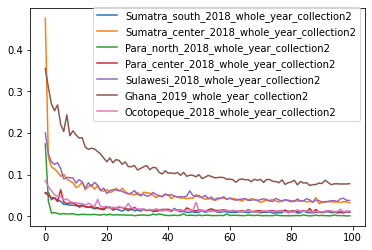

In [123]:
for dataset_idx in np.arange(len(datasets)):
    pl.plot(datasets_losses[dataset_idx], label=datasets_name[dataset_idx])
    
    print(datasets_losses[dataset_idx][-1])

pl.legend(bbox_to_anchor=(1, 1.03))

In [124]:
# remove last layer
model = Model(inputs=model.input, outputs=model.get_layer('last_pretrained_layer').output)

# save model
model.save(os.path.join(MODEL_ROOT_PATH, 'multi_output_pretrained_with_reptile_v4.hdf5'))

## V5 (V4 with january to april)

In [120]:
image_width = 9
image_height = 9
image_depth = len(BANDS)

inputs = Input(shape=(image_width, image_height, image_depth))
layers = Rescaling(0.0000275, offset=0.2)(inputs)
layers = BatchNormalization()(layers)
layers = Conv2D(filters=16, kernel_size=(2, 2), padding="same")(layers)
layers = BatchNormalization()(layers)
layers = Activation(activations.relu)(layers)
layers = Conv2D(filters=16, kernel_size=(2, 2), padding="same")(layers)
layers = BatchNormalization()(layers)
layers = Activation(activations.relu)(layers)
layers = Conv2D(filters=16, kernel_size=(2, 2), padding="same")(layers)
layers = BatchNormalization()(layers)
layers = Activation(activations.relu)(layers)
layers = Conv2D(filters=16, kernel_size=(2, 2), padding="same")(layers)
layers = BatchNormalization()(layers)
layers = Activation(activations.relu)(layers)
layers = Flatten(name="last_pretrained_layer")(layers)
layers = Dense(128, activation='relu')(layers)
layers = Dense(128, activation='relu')(layers)
layers = Dropout(0.5, name="last_input_layer")(layers)

label_output = Dense(len(labels), activation='softmax', name="label")(layers)
category_output = Dense(len(LabelCategory), activation='softmax', name="category")(layers)

model = Model(inputs=inputs, outputs=[label_output, category_output])

In [121]:
# define hyperparameters
meta_step_size = 0.3
nb_iterations = 100
nb_inner_iters = 5
minibatches_size = 32

tasks_output_weights = [None for _ in np.arange(len(datasets))]
datasets_losses = [[] for _ in np.arange(len(datasets))]

for iteration in range(nb_iterations):
    print(f"iteration: {iteration + 1}/{nb_iterations}\n-----------------")
    
    for X_train, Y_train, steps_per_epoch, dataset_idx, nb_labels, nb_categories in iteration_tasks(datasets):
        # Create model with an new output layer for this task
        label_output = Dense(nb_labels, activation='softmax', name="label")(model.get_layer('last_input_layer').output)
        category_output = Dense(nb_categories, activation='softmax', name="category")(model.get_layer('last_input_layer').output)
        
        model = Model(inputs=inputs, outputs=[label_output, category_output])

        model.compile(optimizer='adam', loss={
            'label': categorical_focal_loss([[.25] * nb_labels]),
            'category': categorical_focal_loss([[.25] * nb_categories])
        })
        
        # If task as already been trained on, set back the previous weights of the output layer 
        if tasks_output_weights[dataset_idx] is not None :
            model.layers[-1].set_weights(tasks_output_weights[dataset_idx])        

        # Save old weights
        old_weights = model.get_weights()
        
        # Train
        model.fit(
            x=X_train,
            y=Y_train,
            epochs=nb_inner_iters,
            steps_per_epoch=steps_per_epoch,
            verbose=0
        )
        
        # Evaluate model on training data
        score = model.evaluate(X_train, Y_train, verbose=0)
        
        # Get new weights
        new_weights = model.get_weights()
        
        # Store dataset current loss and accuracies
        datasets_losses[dataset_idx].append(float(score[0]))
        
        print(f"- loss: {score[0]}")

        # Update weights
        for weight in range(len(new_weights)):
            current_meta_step_size = (1 - iteration / nb_iterations) * meta_step_size
            
            new_weights[weight] = old_weights[weight] + (
                (new_weights[weight] - old_weights[weight]) * current_meta_step_size
            )

        # After the meta-learning step, reload the newly-trained weights into the model.
        model.set_weights(new_weights)

        # Save task's output layer weights
        tasks_output_weights[dataset_idx] = model.layers[-1].get_weights()

iteration: 1/100
-----------------
dataset index: 3, dataset iteration: 1/7, size: 14249
- loss: 0.12981067597866058
dataset index: 2, dataset iteration: 2/7, size: 1082
- loss: 0.29909607768058777
dataset index: 1, dataset iteration: 3/7, size: 1996
- loss: 0.5130977034568787
dataset index: 5, dataset iteration: 4/7, size: 6016
- loss: 0.3672771751880646
dataset index: 4, dataset iteration: 5/7, size: 2809
- loss: 0.31054437160491943
dataset index: 0, dataset iteration: 6/7, size: 11324
- loss: 0.10422814637422562
dataset index: 6, dataset iteration: 7/7, size: 58664
- loss: 0.09454740583896637
iteration: 2/100
-----------------
dataset index: 5, dataset iteration: 1/7, size: 6016
- loss: 0.3316636383533478
dataset index: 3, dataset iteration: 2/7, size: 14249
- loss: 0.1075245663523674
dataset index: 0, dataset iteration: 3/7, size: 11324
- loss: 0.08917511999607086
dataset index: 1, dataset iteration: 4/7, size: 1996
- loss: 0.16836412250995636
dataset index: 4, dataset iteration: 5

- loss: 0.09584635496139526
dataset index: 2, dataset iteration: 5/7, size: 1082
- loss: 0.007088313810527325
dataset index: 5, dataset iteration: 6/7, size: 6016
- loss: 0.22509105503559113
dataset index: 4, dataset iteration: 7/7, size: 2809
- loss: 0.11654082685709
iteration: 15/100
-----------------
dataset index: 0, dataset iteration: 1/7, size: 11324
- loss: 0.045215897262096405
dataset index: 1, dataset iteration: 2/7, size: 1996
- loss: 0.08365373313426971
dataset index: 4, dataset iteration: 3/7, size: 2809
- loss: 0.10901486128568649
dataset index: 2, dataset iteration: 4/7, size: 1082
- loss: 0.005647763609886169
dataset index: 3, dataset iteration: 5/7, size: 14249
- loss: 0.05220548063516617
dataset index: 6, dataset iteration: 6/7, size: 58664
- loss: 0.03485758602619171
dataset index: 5, dataset iteration: 7/7, size: 6016
- loss: 0.2208106517791748
iteration: 16/100
-----------------
dataset index: 6, dataset iteration: 1/7, size: 58664
- loss: 0.03549649938941002
datase

- loss: 0.024273913353681564
dataset index: 4, dataset iteration: 2/7, size: 2809
- loss: 0.10907553881406784
dataset index: 5, dataset iteration: 3/7, size: 6016
- loss: 0.17152075469493866
dataset index: 1, dataset iteration: 4/7, size: 1996
- loss: 0.08101338148117065
dataset index: 2, dataset iteration: 5/7, size: 1082
- loss: 0.007681863382458687
dataset index: 3, dataset iteration: 6/7, size: 14249
- loss: 0.03703185170888901
dataset index: 0, dataset iteration: 7/7, size: 11324
- loss: 0.04647596925497055
iteration: 29/100
-----------------
dataset index: 1, dataset iteration: 1/7, size: 1996
- loss: 0.06788614392280579
dataset index: 5, dataset iteration: 2/7, size: 6016
- loss: 0.1603141874074936
dataset index: 6, dataset iteration: 3/7, size: 58664
- loss: 0.025654606521129608
dataset index: 0, dataset iteration: 4/7, size: 11324
- loss: 0.042949602007865906
dataset index: 3, dataset iteration: 5/7, size: 14249
- loss: 0.04241858422756195
dataset index: 4, dataset iteration: 

- loss: 0.15681679546833038
dataset index: 2, dataset iteration: 6/7, size: 1082
- loss: 0.004522537812590599
dataset index: 1, dataset iteration: 7/7, size: 1996
- loss: 0.0806678906083107
iteration: 42/100
-----------------
dataset index: 4, dataset iteration: 1/7, size: 2809
- loss: 0.08666537702083588
dataset index: 0, dataset iteration: 2/7, size: 11324
- loss: 0.040140703320503235
dataset index: 3, dataset iteration: 3/7, size: 14249
- loss: 0.03580009192228317
dataset index: 2, dataset iteration: 4/7, size: 1082
- loss: 0.004403768107295036
dataset index: 6, dataset iteration: 5/7, size: 58664
- loss: 0.02215261198580265
dataset index: 5, dataset iteration: 6/7, size: 6016
- loss: 0.16154897212982178
dataset index: 1, dataset iteration: 7/7, size: 1996
- loss: 0.07559917122125626
iteration: 43/100
-----------------
dataset index: 0, dataset iteration: 1/7, size: 11324
- loss: 0.0365513414144516
dataset index: 2, dataset iteration: 2/7, size: 1082
- loss: 0.00471738213673234
data

- loss: 0.06455451995134354
dataset index: 2, dataset iteration: 3/7, size: 1082
- loss: 0.004256762098520994
dataset index: 3, dataset iteration: 4/7, size: 14249
- loss: 0.0317961722612381
dataset index: 0, dataset iteration: 5/7, size: 11324
- loss: 0.037281084805727005
dataset index: 5, dataset iteration: 6/7, size: 6016
- loss: 0.1422002911567688
dataset index: 4, dataset iteration: 7/7, size: 2809
- loss: 0.0819438248872757
iteration: 56/100
-----------------
dataset index: 1, dataset iteration: 1/7, size: 1996
- loss: 0.06085992977023125
dataset index: 6, dataset iteration: 2/7, size: 58664
- loss: 0.032782863825559616
dataset index: 2, dataset iteration: 3/7, size: 1082
- loss: 0.004039935301989317
dataset index: 5, dataset iteration: 4/7, size: 6016
- loss: 0.13647516071796417
dataset index: 4, dataset iteration: 5/7, size: 2809
- loss: 0.07705015689134598
dataset index: 0, dataset iteration: 6/7, size: 11324
- loss: 0.03647705540060997
dataset index: 3, dataset iteration: 7/7

- loss: 0.018055077642202377
dataset index: 3, dataset iteration: 7/7, size: 14249
- loss: 0.028305893763899803
iteration: 69/100
-----------------
dataset index: 0, dataset iteration: 1/7, size: 11324
- loss: 0.038961540907621384
dataset index: 6, dataset iteration: 2/7, size: 58664
- loss: 0.023856811225414276
dataset index: 3, dataset iteration: 3/7, size: 14249
- loss: 0.033213913440704346
dataset index: 1, dataset iteration: 4/7, size: 1996
- loss: 0.06577900052070618
dataset index: 5, dataset iteration: 5/7, size: 6016
- loss: 0.12902489304542542
dataset index: 2, dataset iteration: 6/7, size: 1082
- loss: 0.004107319284230471
dataset index: 4, dataset iteration: 7/7, size: 2809
- loss: 0.07460153102874756
iteration: 70/100
-----------------
dataset index: 1, dataset iteration: 1/7, size: 1996
- loss: 0.05306924134492874
dataset index: 6, dataset iteration: 2/7, size: 58664
- loss: 0.02069343440234661
dataset index: 5, dataset iteration: 3/7, size: 6016
- loss: 0.1320531666278839

- loss: 0.05481914058327675
dataset index: 5, dataset iteration: 3/7, size: 6016
- loss: 0.12352561205625534
dataset index: 3, dataset iteration: 4/7, size: 14249
- loss: 0.02861466445028782
dataset index: 2, dataset iteration: 5/7, size: 1082
- loss: 0.0044517070055007935
dataset index: 0, dataset iteration: 6/7, size: 11324
- loss: 0.03507407382130623
dataset index: 4, dataset iteration: 7/7, size: 2809
- loss: 0.07070399075746536
iteration: 83/100
-----------------
dataset index: 5, dataset iteration: 1/7, size: 6016
- loss: 0.12351857870817184
dataset index: 6, dataset iteration: 2/7, size: 58664
- loss: 0.022174591198563576
dataset index: 2, dataset iteration: 3/7, size: 1082
- loss: 0.00423874007537961
dataset index: 3, dataset iteration: 4/7, size: 14249
- loss: 0.026643862947821617
dataset index: 0, dataset iteration: 5/7, size: 11324
- loss: 0.030542107298970222
dataset index: 1, dataset iteration: 6/7, size: 1996
- loss: 0.05885975807905197
dataset index: 4, dataset iteration

- loss: 0.002549263881519437
dataset index: 5, dataset iteration: 7/7, size: 6016
- loss: 0.12315371632575989
iteration: 96/100
-----------------
dataset index: 3, dataset iteration: 1/7, size: 14249
- loss: 0.02632036618888378
dataset index: 5, dataset iteration: 2/7, size: 6016
- loss: 0.12898074090480804
dataset index: 2, dataset iteration: 3/7, size: 1082
- loss: 0.00459578912705183
dataset index: 6, dataset iteration: 4/7, size: 58664
- loss: 0.020678192377090454
dataset index: 4, dataset iteration: 5/7, size: 2809
- loss: 0.07198003679513931
dataset index: 1, dataset iteration: 6/7, size: 1996
- loss: 0.05291271582245827
dataset index: 0, dataset iteration: 7/7, size: 11324
- loss: 0.03389900550246239
iteration: 97/100
-----------------
dataset index: 1, dataset iteration: 1/7, size: 1996
- loss: 0.05528273805975914
dataset index: 0, dataset iteration: 2/7, size: 11324
- loss: 0.03259631618857384
dataset index: 4, dataset iteration: 3/7, size: 2809
- loss: 0.07166287302970886
dat

0.03510919585824013
0.05132366716861725
0.0028838985599577427
0.029106318950653076
0.07606888562440872
0.12167254090309143
0.01888221688568592


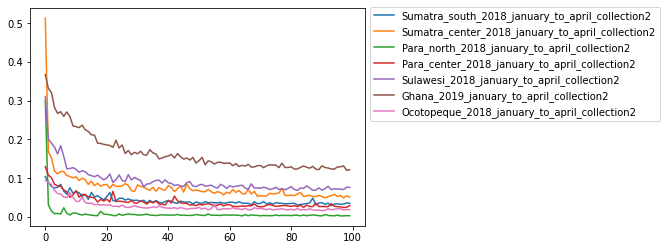

In [122]:
for dataset_idx in np.arange(len(datasets)):
    pl.plot(datasets_losses[dataset_idx], label=datasets_name[dataset_idx])
    
    print(datasets_losses[dataset_idx][-1])

pl.legend(bbox_to_anchor=(1, 1.03))

In [123]:
# remove last layer
model = Model(inputs=model.input, outputs=model.get_layer('last_pretrained_layer').output)

# save model
model.save(os.path.join(MODEL_ROOT_PATH, 'multi_output_pretrained_with_reptile_v5.hdf5'))

# Training with pretrained model

In [76]:
EPOCHS = 500
NB_TESTS = 4

labels = [
    Label.COFFEE,
    Label.DENSE_FOREST,
    Label.RUBBER,
    Label.SEASONAL_AGRICULTURE,
    Label.URBAN,
    Label.WATER,
    Label.OTHER_TREE,
    Label.NATIVE_NO_TREE,
    Label.PEPPER,
    Label.TEA,
    Label.RICE,     
    Label.DECIDUOUS_FOREST,
    Label.PINE_TREES,     
    Label.SHRUBLAND_BUSHLAND,     
    Label.GRASSLAND,     
    Label.SECONDARY_DEGRADED_FOREST,     
    Label.MINE_BARESOIL,
]

labels_names = [label.name for label in labels]
categories = pd.unique([category_from_label(label) for label in labels])

bands = [
    Band.COASTAL_AEROSOL.value, 
    Band.BLUE.value, 
    Band.GREEN.value, 
    Band.RED.value, 
    Band.NIR.value, 
    Band.SWIR1.value, 
    Band.SWIR2.value, 
]

In [77]:
labels_coordinates = vietnam_labels_coordinates()

dataset_args = dict(
    labels = labels,
    raster_paths = [os.path.join(DATA_ROOT_PATH, 'Vietnam_2018_whole_year_collection2/merged.tif')],
    labels_coordinates_list = [labels_coordinates],
    nb_pixel_around = NB_PIXEL_AROUND
)

dataset_2018 = make_dataset_from_raster_files(**dataset_args)

dataset_args = dict(
    labels = labels,
    raster_paths = [os.path.join(DATA_ROOT_PATH, 'Vietnam_2019_whole_year_collection2/merged.tif')],
    labels_coordinates_list = [labels_coordinates],
    nb_pixel_around = NB_PIXEL_AROUND
)

dataset_2019 = make_dataset_from_raster_files(**dataset_args)
np.random.shuffle(dataset_2019)

In [78]:
# Create train sets
labels_train = labels_from_dataset(dataset_2018, labels_names)
categories_train = categories_from_label_set(labels, labels_train)

X_train = images_from_dataset(dataset_2018, bands)
y_train = [labels_train, categories_train]
Y_train = [
    to_categorical(labels_train, num_classes=len(labels_names)), 
    to_categorical(categories_train, num_classes=len(categories)), 
]

# Create test sets
labels_test = labels_from_dataset(dataset_2019, labels_names)
categories_test = categories_from_label_set(labels, labels_test)

X_test = images_from_dataset(dataset_2019, bands)
y_test = [labels_test, categories_test]
Y_test = [
    to_categorical(labels_test, num_classes=len(labels_names)), 
    to_categorical(categories_test, num_classes=len(categories)), 
]

In [10]:
model_name = "whole_year_2018_collection2_with_reptile_v4"

model = load_model(
    os.path.join(MODEL_ROOT_PATH, 'multi_output_pretrained_with_reptile_v4.hdf5'),
    custom_objects={
        'categorical_focal_loss_fixed': categorical_focal_loss
    }
)

layers = model.layers

# Freeze pretrained layers
for layer in layers:
    layer.trainable = False

# Add trainable layers before output layers
layers = Dense(128, activation='relu')(model.get_layer('last_pretrained_layer').output)
layers = Dense(128, activation='relu')(layers)
layers = Dropout(0.25)(layers)

# Define output layers
label_output = Dense(len(labels), activation='softmax', name="label")(layers)
category_output = Dense(len(categories), activation='softmax', name="category")(layers)

# Create model
model = Model(inputs=model.input, outputs=[label_output, category_output])

model.compile(optimizer='adam', loss={
    'label': categorical_focal_loss([[.25] * len(labels)]),
    'category': categorical_focal_loss([[.25] * len(categories)])
}, metrics={
    'label': 'accuracy',
    'category': 'accuracy'
})

model.summary()

Model: "model_1"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_5 (InputLayer)            [(None, 9, 9, 7)]    0                                            
__________________________________________________________________________________________________
rescaling_4 (Rescaling)         (None, 9, 9, 7)      0           input_5[0][0]                    
__________________________________________________________________________________________________
batch_normalization_8 (BatchNor (None, 9, 9, 7)      28          rescaling_4[0][0]                
__________________________________________________________________________________________________
conv2d_16 (Conv2D)              (None, 9, 9, 16)     464         batch_normalization_8[0][0]      
____________________________________________________________________________________________

In [11]:
# create data generators
train_datagen = ImageMultiOutputSequence(
    X_train, Y_train, ['label', 'category'], batch_size=32, augmentations=AUGMENTATIONS
)

history, trained_model = train_model(
    model=model,
    train_datagen=train_datagen,
    validation_datagen=None,
    class_weights=None,
    epochs=EPOCHS,
    steps_per_epoch=len(labels_train) / 32,
    early_stopping=False,
    model_checkpoint_cb=False,
)

trained_model.save(os.path.join(MODEL_ROOT_PATH, model_name + '.hdf5'))

Epoch 1/500
440/440 [==============================] - 2s 3ms/step - loss: 0.4890 - label_loss: 0.3755 - category_loss: 0.1135 - label_accuracy: 0.4166 - category_accuracy: 0.7458
Epoch 2/500
440/440 [==============================] - 1s 3ms/step - loss: 0.2572 - label_loss: 0.2001 - category_loss: 0.0570 - label_accuracy: 0.6107 - category_accuracy: 0.8486
Epoch 3/500
440/440 [==============================] - 1s 3ms/step - loss: 0.2155 - label_loss: 0.1679 - category_loss: 0.0476 - label_accuracy: 0.6617 - category_accuracy: 0.8679
Epoch 4/500
440/440 [==============================] - 1s 3ms/step - loss: 0.1951 - label_loss: 0.1521 - category_loss: 0.0430 - label_accuracy: 0.6803 - category_accuracy: 0.8769
Epoch 5/500
440/440 [==============================] - 1s 3ms/step - loss: 0.1809 - label_loss: 0.1420 - category_loss: 0.0389 - label_accuracy: 0.6878 - category_accuracy: 0.8855
Epoch 6/500
440/440 [==============================] - 1s 3ms/step - loss: 0.1690 - label_loss: 0.13

440/440 [==============================] - 1s 3ms/step - loss: 0.0724 - label_loss: 0.0584 - category_loss: 0.0141 - label_accuracy: 0.8110 - category_accuracy: 0.9430
Epoch 92/500
440/440 [==============================] - 1s 3ms/step - loss: 0.0724 - label_loss: 0.0584 - category_loss: 0.0139 - label_accuracy: 0.8184 - category_accuracy: 0.9433
Epoch 93/500
440/440 [==============================] - 1s 3ms/step - loss: 0.0740 - label_loss: 0.0590 - category_loss: 0.0149 - label_accuracy: 0.8161 - category_accuracy: 0.9409
Epoch 94/500
440/440 [==============================] - 1s 3ms/step - loss: 0.0717 - label_loss: 0.0573 - category_loss: 0.0144 - label_accuracy: 0.8186 - category_accuracy: 0.9410
Epoch 95/500
440/440 [==============================] - 1s 3ms/step - loss: 0.0740 - label_loss: 0.0592 - category_loss: 0.0148 - label_accuracy: 0.8146 - category_accuracy: 0.9426
Epoch 96/500
440/440 [==============================] - 1s 3ms/step - loss: 0.0709 - label_loss: 0.0576 - ca

440/440 [==============================] - 1s 3ms/step - loss: 0.0605 - label_loss: 0.0493 - category_loss: 0.0112 - label_accuracy: 0.8291 - category_accuracy: 0.9502
Epoch 182/500
440/440 [==============================] - 1s 3ms/step - loss: 0.0586 - label_loss: 0.0475 - category_loss: 0.0111 - label_accuracy: 0.8343 - category_accuracy: 0.9513
Epoch 183/500
440/440 [==============================] - 1s 3ms/step - loss: 0.0639 - label_loss: 0.0516 - category_loss: 0.0123 - label_accuracy: 0.8283 - category_accuracy: 0.9478
Epoch 184/500
440/440 [==============================] - 1s 3ms/step - loss: 0.0623 - label_loss: 0.0505 - category_loss: 0.0118 - label_accuracy: 0.8361 - category_accuracy: 0.9479
Epoch 185/500
440/440 [==============================] - 1s 3ms/step - loss: 0.0599 - label_loss: 0.0481 - category_loss: 0.0118 - label_accuracy: 0.8371 - category_accuracy: 0.9510
Epoch 186/500
440/440 [==============================] - 1s 3ms/step - loss: 0.0611 - label_loss: 0.0493

440/440 [==============================] - 1s 3ms/step - loss: 0.0568 - label_loss: 0.0458 - category_loss: 0.0110 - label_accuracy: 0.8458 - category_accuracy: 0.9557
Epoch 272/500
440/440 [==============================] - 1s 3ms/step - loss: 0.0574 - label_loss: 0.0463 - category_loss: 0.0111 - label_accuracy: 0.8434 - category_accuracy: 0.9550
Epoch 273/500
440/440 [==============================] - 1s 3ms/step - loss: 0.0571 - label_loss: 0.0458 - category_loss: 0.0113 - label_accuracy: 0.8452 - category_accuracy: 0.9550
Epoch 274/500
440/440 [==============================] - 1s 3ms/step - loss: 0.0539 - label_loss: 0.0438 - category_loss: 0.0102 - label_accuracy: 0.8472 - category_accuracy: 0.9556
Epoch 275/500
440/440 [==============================] - 1s 3ms/step - loss: 0.0572 - label_loss: 0.0461 - category_loss: 0.0111 - label_accuracy: 0.8453 - category_accuracy: 0.9528
Epoch 276/500
440/440 [==============================] - 1s 3ms/step - loss: 0.0553 - label_loss: 0.0449

440/440 [==============================] - 1s 3ms/step - loss: 0.0557 - label_loss: 0.0453 - category_loss: 0.0104 - label_accuracy: 0.8420 - category_accuracy: 0.9549
Epoch 362/500
440/440 [==============================] - 1s 3ms/step - loss: 0.0518 - label_loss: 0.0419 - category_loss: 0.0099 - label_accuracy: 0.8511 - category_accuracy: 0.9584
Epoch 363/500
440/440 [==============================] - 1s 3ms/step - loss: 0.0530 - label_loss: 0.0427 - category_loss: 0.0103 - label_accuracy: 0.8508 - category_accuracy: 0.9583
Epoch 364/500
440/440 [==============================] - 1s 3ms/step - loss: 0.0525 - label_loss: 0.0429 - category_loss: 0.0096 - label_accuracy: 0.8466 - category_accuracy: 0.9573
Epoch 365/500
440/440 [==============================] - 1s 3ms/step - loss: 0.0531 - label_loss: 0.0433 - category_loss: 0.0098 - label_accuracy: 0.8474 - category_accuracy: 0.9566
Epoch 366/500
440/440 [==============================] - 1s 3ms/step - loss: 0.0505 - label_loss: 0.0416

440/440 [==============================] - 1s 3ms/step - loss: 0.0518 - label_loss: 0.0423 - category_loss: 0.0096 - label_accuracy: 0.8544 - category_accuracy: 0.9614
Epoch 452/500
440/440 [==============================] - 1s 3ms/step - loss: 0.0518 - label_loss: 0.0415 - category_loss: 0.0103 - label_accuracy: 0.8580 - category_accuracy: 0.9600
Epoch 453/500
440/440 [==============================] - 1s 3ms/step - loss: 0.0519 - label_loss: 0.0418 - category_loss: 0.0100 - label_accuracy: 0.8596 - category_accuracy: 0.9584
Epoch 454/500
440/440 [==============================] - 1s 3ms/step - loss: 0.0517 - label_loss: 0.0418 - category_loss: 0.0098 - label_accuracy: 0.8552 - category_accuracy: 0.9583
Epoch 455/500
440/440 [==============================] - 1s 3ms/step - loss: 0.0500 - label_loss: 0.0403 - category_loss: 0.0096 - label_accuracy: 0.8556 - category_accuracy: 0.9613
Epoch 456/500
440/440 [==============================] - 1s 3ms/step - loss: 0.0501 - label_loss: 0.0414

In [12]:
conf_matrices, accuracy, loss = evaluate_multi_output_model(trained_model, X_test, Y_test, y_test)

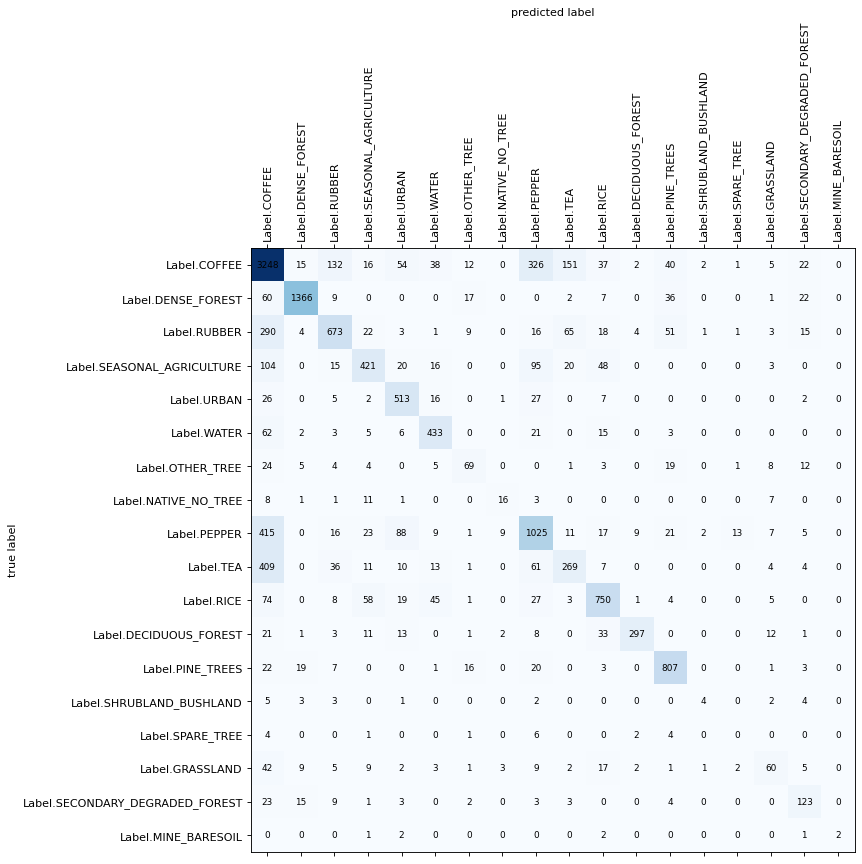

In [15]:
pl.figure(figsize=(12, 10), dpi=80)

plot_confusion_matrix(conf_matrices[0], labels)

In [16]:
recall, precision, fscore = recall_precision_fscore_from_confusion_matrix(conf_matrices[0])

print("Precisions: ", precision)
print("Mean precision: ", np.mean(precision))
print("\nRecalls: ", recall)
print("Mean recall: ", np.mean(recall))
print("\nF-Score: ", fscore)
print("Mean f-score: ", np.mean(fscore))

Precisions:  [0.67149059 0.94861111 0.72443488 0.70637584 0.69795918 0.74655172
 0.52671756 0.51612903 0.62158884 0.51043643 0.7780083  0.93690852
 0.81515152 0.4        0.         0.50847458 0.56164384 1.        ]
Mean precision:  0.6483601074676073

Recalls:  [0.79200195 0.89868421 0.57227891 0.56738544 0.85642738 0.78727273
 0.44516129 0.33333333 0.61340515 0.32606061 0.75376884 0.7369727
 0.89766407 0.16666667 0.         0.34682081 0.66129032 0.25      ]
Mean recall:  0.5558441343763002

F-Score:  [0.72678452 0.92297297 0.63942993 0.62929746 0.76911544 0.76637168
 0.48251748 0.40506329 0.61746988 0.39792899 0.76569678 0.825
 0.85442033 0.23529412        nan 0.41237113 0.60740741 0.4       ]
Mean f-score:  nan


/home/simon/Documents/HEIG/TB/scripts/notebooks/../src/statisticsUtils.py:106: RuntimeWarning: invalid value encountered in true_divide
  fscore = 2 * recall * precision / (recall + precision)


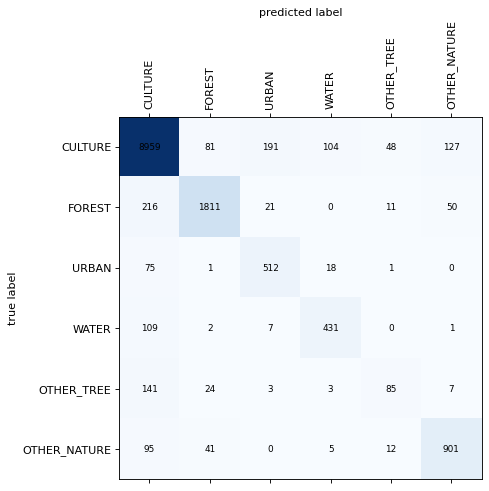

In [17]:
pl.figure(figsize=(8, 6), dpi=80)

plot_confusion_matrix(conf_matrices[1], [category.name for category in categories])

In [18]:
recall, precision, fscore = recall_precision_fscore_from_confusion_matrix(conf_matrices[1])

print("Precisions: ", precision)
print("Mean precision: ", np.mean(precision))
print("\nRecalls: ", recall)
print("Mean recall: ", np.mean(recall))
print("\nF-Score: ", fscore)
print("Mean f-score: ", np.mean(fscore))

Precisions:  [0.93371548 0.92397959 0.69754768 0.76827094 0.54140127 0.82965009]
Mean precision:  0.7824275105465324

Recalls:  [0.94206099 0.85870081 0.84349259 0.78363636 0.32319392 0.85483871]
Mean recall:  0.7676538951094978

F-Score:  [0.93786967 0.890145   0.76360925 0.77587759 0.4047619  0.84205607]
Mean f-score:  0.7690532467525387


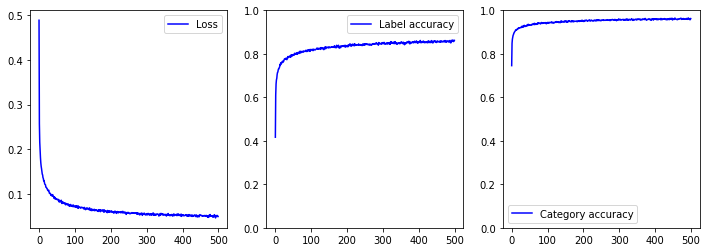

In [61]:
figure, axis = pl.subplots(1, 3, figsize=(12,4))
axis[0].plot(history.history['loss'], label='Loss', color="blue")
axis[0].legend()
axis[1].plot(history.history['label_accuracy'], label='Label accuracy', color="blue")
axis[1].set_ylim([0,1])
axis[1].legend()
axis[2].plot(history.history['category_accuracy'], label='Category accuracy', color="blue")
axis[2].set_ylim([0,1])
axis[2].legend()

### Without freezing layers

In [30]:
EPOCHS = 500

labels = [
    Label.COFFEE,
    Label.DENSE_FOREST,
    Label.RUBBER,
    Label.SEASONAL_AGRICULTURE,
    Label.URBAN,
    Label.WATER,
    Label.OTHER_TREE,
    Label.NATIVE_NO_TREE,
    Label.PEPPER,
    Label.TEA,
    Label.RICE,     
    Label.DECIDUOUS_FOREST,
    Label.PINE_TREES,     
    Label.SHRUBLAND_BUSHLAND,     
    Label.GRASSLAND,     
    Label.SECONDARY_DEGRADED_FOREST,     
    Label.MINE_BARESOIL,
]

labels_names = [label.name for label in labels]
categories = pd.unique([category_from_label(label) for label in labels])

bands = [
    Band.COASTAL_AEROSOL.value, 
    Band.BLUE.value, 
    Band.GREEN.value, 
    Band.RED.value, 
    Band.NIR.value, 
    Band.SWIR1.value, 
    Band.SWIR2.value, 
]

In [31]:
labels_coordinates = vietnam_labels_coordinates()

dataset_args = dict(
    labels = labels,
    raster_paths = [os.path.join(DATA_ROOT_PATH, 'Vietnam_2018_whole_year_collection2/merged.tif')],
    labels_coordinates_list = [labels_coordinates],
    nb_pixel_around = NB_PIXEL_AROUND
)

dataset_2018 = make_dataset_from_raster_files(**dataset_args)

dataset_args = dict(
    labels = labels,
    raster_paths = [os.path.join(DATA_ROOT_PATH, 'Vietnam_2019_whole_year_collection2/merged.tif')],
    labels_coordinates_list = [labels_coordinates],
    nb_pixel_around = NB_PIXEL_AROUND
)

dataset_2019 = make_dataset_from_raster_files(**dataset_args)
np.random.shuffle(dataset_2019)

In [32]:
# Create train sets
labels_train = labels_from_dataset(dataset_2018, labels_names)
categories_train = categories_from_label_set(labels, labels_train)

X_train = images_from_dataset(dataset_2018, bands)
y_train = [labels_train, categories_train]
Y_train = [
    to_categorical(labels_train, num_classes=len(labels_names)), 
    to_categorical(categories_train, num_classes=len(categories)), 
]

# Create test sets
labels_test = labels_from_dataset(dataset_2019, labels_names)
categories_test = categories_from_label_set(labels, labels_test)

X_test = images_from_dataset(dataset_2019, bands)
y_test = [labels_test, categories_test]
Y_test = [
    to_categorical(labels_test, num_classes=len(labels_names)), 
    to_categorical(categories_test, num_classes=len(categories)), 
]

In [6]:
model_name = "whole_year_2018_collection2_with_reptile_v4"

model = load_model(
    os.path.join(MODEL_ROOT_PATH, 'multi_output_pretrained_with_reptile_v4.hdf5'),
    custom_objects={
        'categorical_focal_loss_fixed': categorical_focal_loss
    }
)

layers = model.layers

# Add trainable layers before output layers
layers = Dense(128, activation='relu')(model.get_layer('last_pretrained_layer').output)
layers = Dense(128, activation='relu')(layers)
layers = Dropout(0.25)(layers)

# Define output layers
label_output = Dense(len(labels), activation='softmax', name="label")(layers)
category_output = Dense(len(categories), activation='softmax', name="category")(layers)

# Create model
model = Model(inputs=model.input, outputs=[label_output, category_output])

model.compile(optimizer='adam', loss={
    'label': categorical_focal_loss([[.25] * len(labels)]),
    'category': categorical_focal_loss([[.25] * len(categories)])
}, metrics={
    'label': 'accuracy',
    'category': 'accuracy'
})

model.summary()

Model: "model"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_5 (InputLayer)            [(None, 9, 9, 7)]    0                                            
__________________________________________________________________________________________________
rescaling_4 (Rescaling)         (None, 9, 9, 7)      0           input_5[0][0]                    
__________________________________________________________________________________________________
batch_normalization_8 (BatchNor (None, 9, 9, 7)      28          rescaling_4[0][0]                
__________________________________________________________________________________________________
conv2d_16 (Conv2D)              (None, 9, 9, 16)     464         batch_normalization_8[0][0]      
______________________________________________________________________________________________

In [7]:
# create data generators
train_datagen = ImageMultiOutputSequence(
    X_train, Y_train, ['label', 'category'], batch_size=32, augmentations=AUGMENTATIONS
)

history, trained_model = train_model(
    model=model,
    train_datagen=train_datagen,
    validation_datagen=None,
    class_weights=None,
    epochs=EPOCHS,
    steps_per_epoch=len(labels_train) / 32,
    early_stopping=False,
    model_checkpoint_cb=False,
)

trained_model.save(os.path.join(MODEL_ROOT_PATH, model_name + '.hdf5'))

Epoch 1/500
440/440 [==============================] - 2s 4ms/step - loss: 0.6308 - label_loss: 0.4683 - category_loss: 0.1625 - label_accuracy: 0.2866 - category_accuracy: 0.6780
Epoch 2/500
440/440 [==============================] - 2s 4ms/step - loss: 0.3175 - label_loss: 0.2436 - category_loss: 0.0738 - label_accuracy: 0.5579 - category_accuracy: 0.8104
Epoch 3/500
440/440 [==============================] - 2s 4ms/step - loss: 0.2331 - label_loss: 0.1807 - category_loss: 0.0525 - label_accuracy: 0.6348 - category_accuracy: 0.8535
Epoch 4/500
440/440 [==============================] - 2s 4ms/step - loss: 0.2051 - label_loss: 0.1595 - category_loss: 0.0456 - label_accuracy: 0.6644 - category_accuracy: 0.8687
Epoch 5/500
440/440 [==============================] - 2s 4ms/step - loss: 0.1888 - label_loss: 0.1481 - category_loss: 0.0407 - label_accuracy: 0.6847 - category_accuracy: 0.8783
Epoch 6/500
440/440 [==============================] - 2s 4ms/step - loss: 0.1772 - label_loss: 0.13

440/440 [==============================] - 2s 4ms/step - loss: 0.0794 - label_loss: 0.0623 - category_loss: 0.0171 - label_accuracy: 0.8145 - category_accuracy: 0.9328
Epoch 92/500
440/440 [==============================] - 2s 4ms/step - loss: 0.0795 - label_loss: 0.0622 - category_loss: 0.0173 - label_accuracy: 0.8178 - category_accuracy: 0.9320
Epoch 93/500
440/440 [==============================] - 2s 4ms/step - loss: 0.0758 - label_loss: 0.0597 - category_loss: 0.0161 - label_accuracy: 0.8203 - category_accuracy: 0.9344
Epoch 94/500
440/440 [==============================] - 2s 4ms/step - loss: 0.0764 - label_loss: 0.0599 - category_loss: 0.0165 - label_accuracy: 0.8194 - category_accuracy: 0.9339
Epoch 95/500
440/440 [==============================] - 2s 4ms/step - loss: 0.0741 - label_loss: 0.0583 - category_loss: 0.0158 - label_accuracy: 0.8208 - category_accuracy: 0.9356
Epoch 96/500
440/440 [==============================] - 2s 4ms/step - loss: 0.0748 - label_loss: 0.0589 - ca

440/440 [==============================] - 2s 4ms/step - loss: 0.0612 - label_loss: 0.0483 - category_loss: 0.0129 - label_accuracy: 0.8379 - category_accuracy: 0.9452
Epoch 182/500
440/440 [==============================] - 2s 4ms/step - loss: 0.0648 - label_loss: 0.0509 - category_loss: 0.0139 - label_accuracy: 0.8386 - category_accuracy: 0.9415
Epoch 183/500
440/440 [==============================] - 2s 4ms/step - loss: 0.0611 - label_loss: 0.0484 - category_loss: 0.0127 - label_accuracy: 0.8469 - category_accuracy: 0.9476
Epoch 184/500
440/440 [==============================] - 2s 4ms/step - loss: 0.0620 - label_loss: 0.0489 - category_loss: 0.0130 - label_accuracy: 0.8420 - category_accuracy: 0.9444
Epoch 185/500
440/440 [==============================] - 2s 4ms/step - loss: 0.0648 - label_loss: 0.0509 - category_loss: 0.0139 - label_accuracy: 0.8404 - category_accuracy: 0.9437
Epoch 186/500
440/440 [==============================] - 2s 4ms/step - loss: 0.0620 - label_loss: 0.0490

440/440 [==============================] - 2s 5ms/step - loss: 0.0560 - label_loss: 0.0437 - category_loss: 0.0123 - label_accuracy: 0.8536 - category_accuracy: 0.9486
Epoch 272/500
440/440 [==============================] - 2s 5ms/step - loss: 0.0547 - label_loss: 0.0427 - category_loss: 0.0120 - label_accuracy: 0.8575 - category_accuracy: 0.9513
Epoch 273/500
440/440 [==============================] - 2s 5ms/step - loss: 0.0542 - label_loss: 0.0430 - category_loss: 0.0112 - label_accuracy: 0.8587 - category_accuracy: 0.9496
Epoch 274/500
440/440 [==============================] - 2s 5ms/step - loss: 0.0579 - label_loss: 0.0453 - category_loss: 0.0126 - label_accuracy: 0.8535 - category_accuracy: 0.9469
Epoch 275/500
440/440 [==============================] - 2s 4ms/step - loss: 0.0551 - label_loss: 0.0430 - category_loss: 0.0121 - label_accuracy: 0.8540 - category_accuracy: 0.9488
Epoch 276/500
440/440 [==============================] - 2s 4ms/step - loss: 0.0521 - label_loss: 0.0408

440/440 [==============================] - 2s 4ms/step - loss: 0.0487 - label_loss: 0.0384 - category_loss: 0.0103 - label_accuracy: 0.8656 - category_accuracy: 0.9540
Epoch 362/500
440/440 [==============================] - 2s 4ms/step - loss: 0.0499 - label_loss: 0.0390 - category_loss: 0.0109 - label_accuracy: 0.8648 - category_accuracy: 0.9543
Epoch 363/500
440/440 [==============================] - 2s 4ms/step - loss: 0.0509 - label_loss: 0.0396 - category_loss: 0.0113 - label_accuracy: 0.8614 - category_accuracy: 0.9511
Epoch 364/500
440/440 [==============================] - 2s 4ms/step - loss: 0.0494 - label_loss: 0.0387 - category_loss: 0.0106 - label_accuracy: 0.8626 - category_accuracy: 0.9532
Epoch 365/500
440/440 [==============================] - 2s 4ms/step - loss: 0.0498 - label_loss: 0.0393 - category_loss: 0.0105 - label_accuracy: 0.8636 - category_accuracy: 0.9521
Epoch 366/500
440/440 [==============================] - 2s 4ms/step - loss: 0.0493 - label_loss: 0.0388

440/440 [==============================] - 2s 4ms/step - loss: 0.0493 - label_loss: 0.0388 - category_loss: 0.0105 - label_accuracy: 0.8670 - category_accuracy: 0.9549
Epoch 452/500
440/440 [==============================] - 2s 4ms/step - loss: 0.0475 - label_loss: 0.0371 - category_loss: 0.0104 - label_accuracy: 0.8690 - category_accuracy: 0.9544
Epoch 453/500
440/440 [==============================] - 2s 4ms/step - loss: 0.0495 - label_loss: 0.0389 - category_loss: 0.0106 - label_accuracy: 0.8654 - category_accuracy: 0.9540
Epoch 454/500
440/440 [==============================] - 2s 5ms/step - loss: 0.0476 - label_loss: 0.0372 - category_loss: 0.0104 - label_accuracy: 0.8671 - category_accuracy: 0.9561
Epoch 455/500
440/440 [==============================] - 3s 6ms/step - loss: 0.0476 - label_loss: 0.0373 - category_loss: 0.0102 - label_accuracy: 0.8677 - category_accuracy: 0.9552
Epoch 456/500
440/440 [==============================] - 2s 5ms/step - loss: 0.0464 - label_loss: 0.0366

In [8]:
conf_matrices, accuracy, loss = evaluate_multi_output_model(trained_model, X_test, Y_test, y_test)

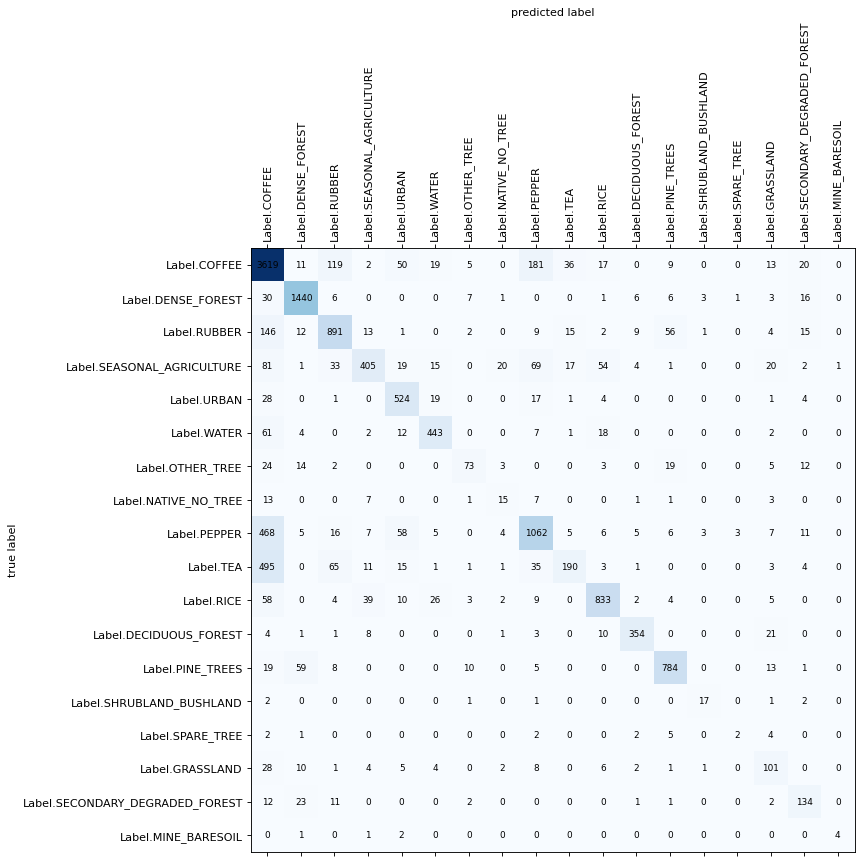

In [9]:
pl.figure(figsize=(12, 10), dpi=80)

plot_confusion_matrix(conf_matrices[0], labels)

In [10]:
recall, precision, fscore = recall_precision_fscore_from_confusion_matrix(conf_matrices[0])

print("Precisions: ", precision)
print("Mean precision: ", np.mean(precision))
print("\nRecalls: ", recall)
print("Mean recall: ", np.mean(recall))
print("\nF-Score: ", fscore)
print("Mean f-score: ", np.mean(fscore))

Precisions:  [0.71100196 0.9102402  0.76943005 0.81162325 0.75287356 0.83270677
 0.6952381  0.30612245 0.75053004 0.71698113 0.87042842 0.91472868
 0.87793953 0.68       0.33333333 0.48557692 0.60633484 0.8       ]
Mean precision:  0.7125049577233724

Recalls:  [0.88246769 0.94736842 0.75765306 0.5458221  0.87479132 0.80545455
 0.47096774 0.3125     0.63554758 0.23030303 0.83718593 0.87841191
 0.87208009 0.70833333 0.11111111 0.58381503 0.72043011 0.5       ]
Mean recall:  0.6485690554749227

F-Score:  [0.78750952 0.92843327 0.76349614 0.65269944 0.80926641 0.81885397
 0.56153846 0.30927835 0.6882696  0.34862385 0.85348361 0.89620253
 0.875      0.69387755 0.16666667 0.53018373 0.65847666 0.61538462]
Mean f-score:  0.6642913543913448


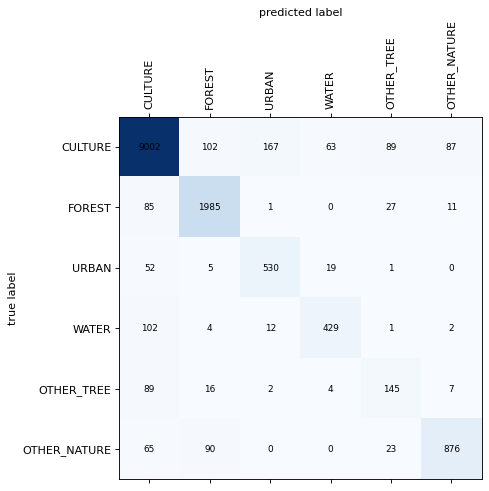

In [11]:
pl.figure(figsize=(8, 6), dpi=80)

plot_confusion_matrix(conf_matrices[1], [category.name for category in categories])

In [12]:
recall, precision, fscore = recall_precision_fscore_from_confusion_matrix(conf_matrices[1])

print("Precisions: ", precision)
print("Mean precision: ", np.mean(precision))
print("\nRecalls: ", recall)
print("Mean recall: ", np.mean(recall))
print("\nF-Score: ", fscore)
print("Mean f-score: ", np.mean(fscore))

Precisions:  [0.95816924 0.90145322 0.74438202 0.83300971 0.50699301 0.89114954]
Mean precision:  0.8058594572864802

Recalls:  [0.94658254 0.94120436 0.87314662 0.78       0.5513308  0.83111954]
Mean recall:  0.8205639787921122

F-Score:  [0.95234065 0.92090002 0.80363912 0.8056338  0.52823315 0.86008837]
Mean f-score:  0.811805852267958


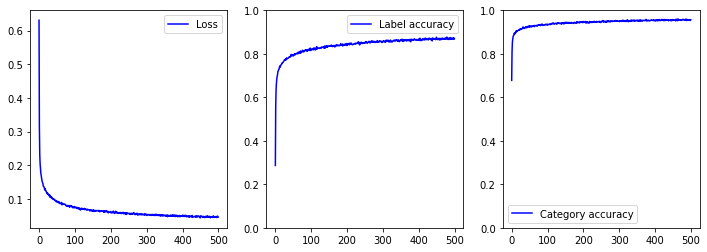

In [13]:
figure, axis = pl.subplots(1, 3, figsize=(12,4))
axis[0].plot(history.history['loss'], label='Loss', color="blue")
axis[0].legend()
axis[1].plot(history.history['label_accuracy'], label='Label accuracy', color="blue")
axis[1].set_ylim([0,1])
axis[1].legend()
axis[2].plot(history.history['category_accuracy'], label='Category accuracy', color="blue")
axis[2].set_ylim([0,1])
axis[2].legend()

### With January to April

In [14]:
EPOCHS = 500
NB_TESTS = 4

labels = [
    Label.COFFEE,
    Label.DENSE_FOREST,
    Label.RUBBER,
    Label.SEASONAL_AGRICULTURE,
    Label.URBAN,
    Label.WATER,
    Label.OTHER_TREE,
    Label.NATIVE_NO_TREE,
    Label.PEPPER,
    Label.TEA,
    Label.RICE,     
    Label.DECIDUOUS_FOREST,
    Label.PINE_TREES,     
    Label.SHRUBLAND_BUSHLAND,     
    Label.GRASSLAND,     
    Label.SECONDARY_DEGRADED_FOREST,     
    Label.MINE_BARESOIL,
]

labels_names = [label.name for label in labels]
categories = pd.unique([category_from_label(label) for label in labels])

bands = [
    Band.COASTAL_AEROSOL.value, 
    Band.BLUE.value, 
    Band.GREEN.value, 
    Band.RED.value, 
    Band.NIR.value, 
    Band.SWIR1.value, 
    Band.SWIR2.value, 
]

In [15]:
labels_coordinates = vietnam_labels_coordinates()

dataset_args = dict(
    labels = labels,
    raster_paths = [os.path.join(DATA_ROOT_PATH, 'Vietnam_2018_january_to_april_collection2/merged.tif')],
    labels_coordinates_list = [labels_coordinates],
    nb_pixel_around = NB_PIXEL_AROUND
)

dataset_2018 = make_dataset_from_raster_files(**dataset_args)

dataset_args = dict(
    labels = labels,
    raster_paths = [os.path.join(DATA_ROOT_PATH, 'Vietnam_2019_january_to_april_collection2/merged.tif')],
    labels_coordinates_list = [labels_coordinates],
    nb_pixel_around = NB_PIXEL_AROUND
)

dataset_2019 = make_dataset_from_raster_files(**dataset_args)
np.random.shuffle(dataset_2019)

In [16]:
# Create train sets
labels_train = labels_from_dataset(dataset_2018, labels_names)
categories_train = categories_from_label_set(labels, labels_train)

X_train = images_from_dataset(dataset_2018, bands)
y_train = [labels_train, categories_train]
Y_train = [
    to_categorical(labels_train, num_classes=len(labels_names)), 
    to_categorical(categories_train, num_classes=len(categories)), 
]

# Create test sets
labels_test = labels_from_dataset(dataset_2019, labels_names)
categories_test = categories_from_label_set(labels, labels_test)

X_test = images_from_dataset(dataset_2019, bands)
y_test = [labels_test, categories_test]
Y_test = [
    to_categorical(labels_test, num_classes=len(labels_names)), 
    to_categorical(categories_test, num_classes=len(categories)), 
]

In [17]:
model_name = "january_to_april_2018_collection2_with_reptile_v5"

model = load_model(
    os.path.join(MODEL_ROOT_PATH, 'multi_output_pretrained_with_reptile_v5.hdf5'),
    custom_objects={
        'categorical_focal_loss_fixed': categorical_focal_loss
    }
)

layers = model.layers

# Add trainable layers before output layers
layers = Dense(128, activation='relu')(model.get_layer('last_pretrained_layer').output)
layers = Dropout(0.25)(layers)

# Define output layers
label_output = Dense(len(labels), activation='softmax', name="label")(layers)
category_output = Dense(len(categories), activation='softmax', name="category")(layers)

# Create model
model = Model(inputs=model.input, outputs=[label_output, category_output])

model.compile(optimizer='adam', loss={
    'label': categorical_focal_loss([[.25] * len(labels)]),
    'category': categorical_focal_loss([[.25] * len(categories)])
}, metrics={
    'label': 'accuracy',
    'category': 'accuracy'
})

model.summary()

Model: "model_1"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_5 (InputLayer)            [(None, 9, 9, 7)]    0                                            
__________________________________________________________________________________________________
rescaling_4 (Rescaling)         (None, 9, 9, 7)      0           input_5[0][0]                    
__________________________________________________________________________________________________
batch_normalization_12 (BatchNo (None, 9, 9, 7)      28          rescaling_4[0][0]                
__________________________________________________________________________________________________
conv2d_16 (Conv2D)              (None, 9, 9, 16)     464         batch_normalization_12[0][0]     
____________________________________________________________________________________________

In [18]:
# create data generators
train_datagen = ImageMultiOutputSequence(
    X_train, Y_train, ['label', 'category'], batch_size=32, augmentations=AUGMENTATIONS
)

history, trained_model = train_model(
    model=model,
    train_datagen=train_datagen,
    validation_datagen=None,
    class_weights=None,
    epochs=EPOCHS,
    steps_per_epoch=len(labels_train) / 32,
    early_stopping=False,
    model_checkpoint_cb=False,
)

trained_model.save(os.path.join(MODEL_ROOT_PATH, model_name + '.hdf5'))

Epoch 1/500
440/440 [==============================] - 2s 4ms/step - loss: 0.6395 - label_loss: 0.4783 - category_loss: 0.1612 - label_accuracy: 0.3035 - category_accuracy: 0.6765
Epoch 2/500
440/440 [==============================] - 2s 4ms/step - loss: 0.3487 - label_loss: 0.2668 - category_loss: 0.0819 - label_accuracy: 0.5232 - category_accuracy: 0.7913
Epoch 3/500
440/440 [==============================] - 2s 4ms/step - loss: 0.2623 - label_loss: 0.2028 - category_loss: 0.0596 - label_accuracy: 0.6152 - category_accuracy: 0.8374
Epoch 4/500
440/440 [==============================] - 2s 4ms/step - loss: 0.2350 - label_loss: 0.1824 - category_loss: 0.0526 - label_accuracy: 0.6410 - category_accuracy: 0.8518
Epoch 5/500
440/440 [==============================] - 2s 4ms/step - loss: 0.2186 - label_loss: 0.1706 - category_loss: 0.0480 - label_accuracy: 0.6554 - category_accuracy: 0.8587
Epoch 6/500
440/440 [==============================] - 2s 4ms/step - loss: 0.2078 - label_loss: 0.16

440/440 [==============================] - 2s 5ms/step - loss: 0.1116 - label_loss: 0.0864 - category_loss: 0.0252 - label_accuracy: 0.7750 - category_accuracy: 0.9102
Epoch 92/500
440/440 [==============================] - 2s 5ms/step - loss: 0.1095 - label_loss: 0.0848 - category_loss: 0.0247 - label_accuracy: 0.7733 - category_accuracy: 0.9117
Epoch 93/500
440/440 [==============================] - 3s 6ms/step - loss: 0.1082 - label_loss: 0.0841 - category_loss: 0.0241 - label_accuracy: 0.7767 - category_accuracy: 0.9095
Epoch 94/500
440/440 [==============================] - 2s 4ms/step - loss: 0.1089 - label_loss: 0.0845 - category_loss: 0.0245 - label_accuracy: 0.7736 - category_accuracy: 0.9135
Epoch 95/500
440/440 [==============================] - 2s 4ms/step - loss: 0.1088 - label_loss: 0.0846 - category_loss: 0.0242 - label_accuracy: 0.7768 - category_accuracy: 0.9126
Epoch 96/500
440/440 [==============================] - 2s 4ms/step - loss: 0.1094 - label_loss: 0.0846 - ca

440/440 [==============================] - 2s 4ms/step - loss: 0.0922 - label_loss: 0.0721 - category_loss: 0.0201 - label_accuracy: 0.7978 - category_accuracy: 0.9225
Epoch 182/500
440/440 [==============================] - 2s 4ms/step - loss: 0.0910 - label_loss: 0.0706 - category_loss: 0.0204 - label_accuracy: 0.8018 - category_accuracy: 0.9204
Epoch 183/500
440/440 [==============================] - 2s 4ms/step - loss: 0.0958 - label_loss: 0.0753 - category_loss: 0.0205 - label_accuracy: 0.7910 - category_accuracy: 0.9202
Epoch 184/500
440/440 [==============================] - 2s 4ms/step - loss: 0.0922 - label_loss: 0.0716 - category_loss: 0.0206 - label_accuracy: 0.8010 - category_accuracy: 0.9217
Epoch 185/500
440/440 [==============================] - 2s 4ms/step - loss: 0.0914 - label_loss: 0.0711 - category_loss: 0.0203 - label_accuracy: 0.7982 - category_accuracy: 0.9212
Epoch 186/500
440/440 [==============================] - 2s 4ms/step - loss: 0.0899 - label_loss: 0.0699

440/440 [==============================] - 2s 5ms/step - loss: 0.0864 - label_loss: 0.0677 - category_loss: 0.0186 - label_accuracy: 0.8032 - category_accuracy: 0.9245
Epoch 272/500
440/440 [==============================] - 2s 4ms/step - loss: 0.0843 - label_loss: 0.0661 - category_loss: 0.0182 - label_accuracy: 0.8086 - category_accuracy: 0.9288
Epoch 273/500
440/440 [==============================] - 2s 4ms/step - loss: 0.0841 - label_loss: 0.0665 - category_loss: 0.0176 - label_accuracy: 0.8033 - category_accuracy: 0.9258
Epoch 274/500
440/440 [==============================] - 2s 4ms/step - loss: 0.0851 - label_loss: 0.0661 - category_loss: 0.0190 - label_accuracy: 0.8054 - category_accuracy: 0.9250
Epoch 275/500
440/440 [==============================] - 2s 5ms/step - loss: 0.0869 - label_loss: 0.0672 - category_loss: 0.0197 - label_accuracy: 0.8113 - category_accuracy: 0.9281
Epoch 276/500
440/440 [==============================] - 2s 5ms/step - loss: 0.0838 - label_loss: 0.0650

440/440 [==============================] - 2s 4ms/step - loss: 0.0844 - label_loss: 0.0653 - category_loss: 0.0191 - label_accuracy: 0.8144 - category_accuracy: 0.9287
Epoch 362/500
440/440 [==============================] - 2s 4ms/step - loss: 0.0788 - label_loss: 0.0616 - category_loss: 0.0172 - label_accuracy: 0.8149 - category_accuracy: 0.9295
Epoch 363/500
440/440 [==============================] - 2s 4ms/step - loss: 0.0805 - label_loss: 0.0627 - category_loss: 0.0178 - label_accuracy: 0.8148 - category_accuracy: 0.9293
Epoch 364/500
440/440 [==============================] - 2s 4ms/step - loss: 0.0818 - label_loss: 0.0633 - category_loss: 0.0185 - label_accuracy: 0.8181 - category_accuracy: 0.9274
Epoch 365/500
440/440 [==============================] - 2s 4ms/step - loss: 0.0810 - label_loss: 0.0629 - category_loss: 0.0181 - label_accuracy: 0.8164 - category_accuracy: 0.9281
Epoch 366/500
440/440 [==============================] - 2s 4ms/step - loss: 0.0788 - label_loss: 0.0612

440/440 [==============================] - 2s 4ms/step - loss: 0.0779 - label_loss: 0.0606 - category_loss: 0.0173 - label_accuracy: 0.8225 - category_accuracy: 0.9304
Epoch 452/500
440/440 [==============================] - 2s 5ms/step - loss: 0.0763 - label_loss: 0.0592 - category_loss: 0.0171 - label_accuracy: 0.8241 - category_accuracy: 0.9297
Epoch 453/500
440/440 [==============================] - 2s 5ms/step - loss: 0.0753 - label_loss: 0.0587 - category_loss: 0.0165 - label_accuracy: 0.8227 - category_accuracy: 0.9327
Epoch 454/500
440/440 [==============================] - 2s 4ms/step - loss: 0.0797 - label_loss: 0.0623 - category_loss: 0.0174 - label_accuracy: 0.8183 - category_accuracy: 0.9302
Epoch 455/500
440/440 [==============================] - 2s 4ms/step - loss: 0.0791 - label_loss: 0.0618 - category_loss: 0.0172 - label_accuracy: 0.8161 - category_accuracy: 0.9329
Epoch 456/500
440/440 [==============================] - 2s 4ms/step - loss: 0.0746 - label_loss: 0.0584

In [19]:
conf_matrices, accuracy, loss = evaluate_multi_output_model(trained_model, X_test, Y_test, y_test)

In [20]:
print("loss: ", loss)
print("accuracy: ", accuracy)

loss:  0.17001980543136597
accuracy:  0.13545697927474976


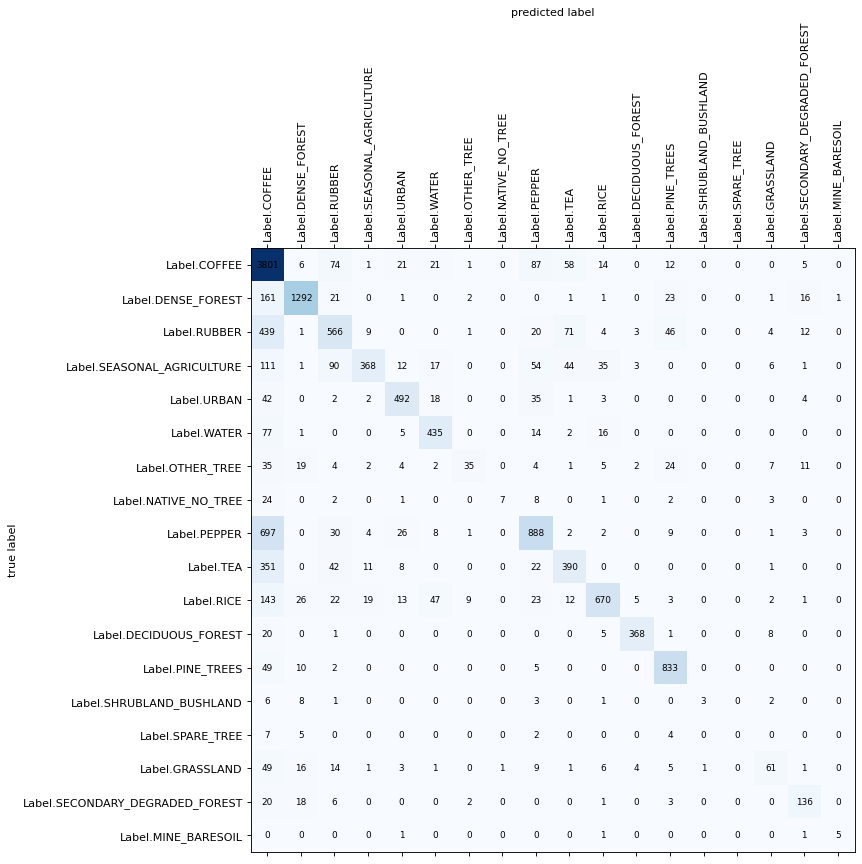

In [21]:
pl.figure(figsize=(12, 10), dpi=80)

plot_confusion_matrix(conf_matrices[0], labels)

In [22]:
recall, precision, fscore = recall_precision_fscore_from_confusion_matrix(conf_matrices[0])

print("Precisions: ", precision)
print("Mean precision: ", np.mean(precision))
print("\nRecalls: ", recall)
print("Mean recall: ", np.mean(recall))
print("\nF-Score: ", fscore)
print("Mean f-score: ", np.mean(fscore))

Precisions:  [0.63013926 0.92088382 0.64538198 0.882494   0.83816014 0.79234973
 0.68627451 0.875      0.75638842 0.66895369 0.87581699 0.95584416
 0.86321244 0.75              nan 0.63541667 0.71204188 0.83333333]
Mean precision:  nan

Recalls:  [0.92684711 0.85       0.48129252 0.49595687 0.82136895 0.79090909
 0.22580645 0.14583333 0.53141831 0.47272727 0.67336683 0.91315136
 0.92658509 0.125      0.         0.35260116 0.7311828  0.625     ]
Mean recall:  0.5605026197363006

F-Score:  [0.75022205 0.88402326 0.55138821 0.6350302  0.8296796  0.79162875
 0.33980583 0.25       0.62425308 0.55397727 0.76136364 0.93401015
 0.89377682 0.21428571        nan 0.4535316  0.72148541 0.71428571]
Mean f-score:  nan


/home/simon/Documents/HEIG/TB/scripts/notebooks/../src/statisticsUtils.py:104: RuntimeWarning: invalid value encountered in true_divide
  precision = tp / (tp + fp)


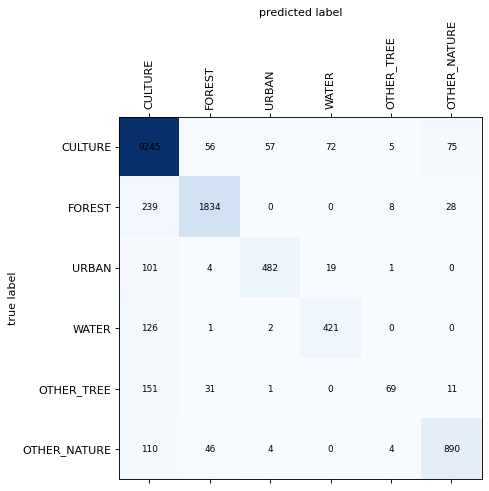

In [23]:
pl.figure(figsize=(8, 6), dpi=80)

plot_confusion_matrix(conf_matrices[1], [category.name for category in categories])

In [24]:
recall, precision, fscore = recall_precision_fscore_from_confusion_matrix(conf_matrices[1])

print("Precisions: ", precision)
print("Mean precision: ", np.mean(precision))
print("\nRecalls: ", recall)
print("Mean recall: ", np.mean(recall))
print("\nF-Score: ", fscore)
print("Mean f-score: ", np.mean(fscore))

Precisions:  [0.92709587 0.93002028 0.88278388 0.82226562 0.79310345 0.88645418]
Mean precision:  0.8736205486223242

Recalls:  [0.9721346  0.86960645 0.79406919 0.76545455 0.26235741 0.84440228]
Mean recall:  0.7513374122351837

F-Score:  [0.9490812  0.89879931 0.83607979 0.79284369 0.39428571 0.8649174 ]
Mean f-score:  0.789334518311172


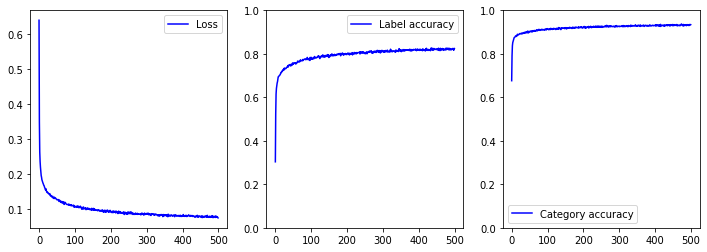

In [25]:
figure, axis = pl.subplots(1, 3, figsize=(12,4))
axis[0].plot(history.history['loss'], label='Loss', color="blue")
axis[0].legend()
axis[1].plot(history.history['label_accuracy'], label='Label accuracy', color="blue")
axis[1].set_ylim([0,1])
axis[1].legend()
axis[2].plot(history.history['category_accuracy'], label='Category accuracy', color="blue")
axis[2].set_ylim([0,1])
axis[2].legend()

### Final model with cross validation

In [3]:
EPOCHS = 2000
NB_TESTS = 4

labels = [
    Label.COFFEE,
    Label.DENSE_FOREST,
    Label.RUBBER,
    Label.SEASONAL_AGRICULTURE,
    Label.URBAN,
    Label.WATER,
    Label.OTHER_TREE,
    Label.NATIVE_NO_TREE,
    Label.PEPPER,
    Label.TEA,
    Label.RICE,     
    Label.DECIDUOUS_FOREST,
    Label.PINE_TREES,     
    Label.SHRUBLAND_BUSHLAND,     
    Label.GRASSLAND,     
    Label.SECONDARY_DEGRADED_FOREST,     
    Label.MINE_BARESOIL,
]

labels_names = [label.name for label in labels]
categories = pd.unique([category_from_label(label) for label in labels])

bands = [
    Band.COASTAL_AEROSOL.value, 
    Band.BLUE.value, 
    Band.GREEN.value, 
    Band.RED.value, 
    Band.NIR.value, 
    Band.SWIR1.value, 
    Band.SWIR2.value, 
]

In [4]:
labels_coordinates = vietnam_labels_coordinates()

dataset_args = dict(
    labels = labels,
    raster_paths = [os.path.join(DATA_ROOT_PATH, 'Vietnam_2018_whole_year_collection2/merged.tif')],
    labels_coordinates_list = [labels_coordinates],
    nb_pixel_around = NB_PIXEL_AROUND
)

dataset = make_dataset_from_raster_files(**dataset_args)

np.random.shuffle(dataset)

In [5]:
model_name = "final_reptile_model"

model = load_model(
    os.path.join(MODEL_ROOT_PATH, 'multi_output_pretrained_with_reptile_v4.hdf5'),
    custom_objects={
        'categorical_focal_loss_fixed': categorical_focal_loss
    }
)

layers = model.layers

# Add trainable layers before output layers
layers = Dense(128, activation='relu')(model.get_layer('last_pretrained_layer').output)
layers = Dense(128, activation='relu')(layers)
layers = Dropout(0.25)(layers)

# Define output layers
label_output = Dense(len(labels), activation='softmax', name="label")(layers)
category_output = Dense(len(categories), activation='softmax', name="category")(layers)

# Create model
model = Model(inputs=model.input, outputs=[label_output, category_output])

model.compile(optimizer='adam', loss={
    'label': categorical_focal_loss([[.25] * len(labels)]),
    'category': categorical_focal_loss([[.25] * len(categories)])
}, metrics={
    'label': 'accuracy',
    'category': 'accuracy'
})

model.summary()

Model: "model"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_5 (InputLayer)            [(None, 9, 9, 7)]    0                                            
__________________________________________________________________________________________________
rescaling_4 (Rescaling)         (None, 9, 9, 7)      0           input_5[0][0]                    
__________________________________________________________________________________________________
batch_normalization_8 (BatchNor (None, 9, 9, 7)      28          rescaling_4[0][0]                
__________________________________________________________________________________________________
conv2d_16 (Conv2D)              (None, 9, 9, 16)     464         batch_normalization_8[0][0]      
______________________________________________________________________________________________

In [6]:
mean_loss, mean_accuracy, histories, conf_matrix = cross_validation_multi_output_model(model, dataset, bands, labels, EPOCHS, NB_TESTS, early_stopping=True, with_model_checkpoint=True, model_name=model_name, categories=categories)

NameError: name 'cross_validation_multi_output_model' is not defined

In [ ]:
conf_matrices, accuracy, loss = evaluate_multi_output_model(trained_model, X_test, Y_test, y_test)

In [ ]:
pl.figure(figsize=(12, 10), dpi=80)

plot_confusion_matrix(conf_matrices[0], labels)

In [ ]:
recall, precision, fscore = recall_precision_fscore_from_confusion_matrix(conf_matrices[0])

print("Precisions: ", precision)
print("Mean precision: ", np.mean(precision))
print("\nRecalls: ", recall)
print("Mean recall: ", np.mean(recall))
print("\nF-Score: ", fscore)
print("Mean f-score: ", np.mean(fscore))

In [ ]:
pl.figure(figsize=(8, 6), dpi=80)

plot_confusion_matrix(conf_matrices[1], [category.name for category in categories])

In [ ]:
recall, precision, fscore = recall_precision_fscore_from_confusion_matrix(conf_matrices[1])

print("Precisions: ", precision)
print("Mean precision: ", np.mean(precision))
print("\nRecalls: ", recall)
print("Mean recall: ", np.mean(recall))
print("\nF-Score: ", fscore)
print("Mean f-score: ", np.mean(fscore))

In [ ]:
for i, history in enumerate(histories):
    pl.plot(history.history['f1_score_train'], label='Training', color="blue")
    pl.plot(history.history['f1_score_val'], label='Testing', color="orange")
    
    if i == 0:
        pl.legend()
        
    pl.grid()